## SET ENV

In [1]:
import numpy as np                #for array manipulation
import pandas as pd               #data manipulation
from sklearn import preprocessing #scaling
import keras
from keras.layers import Dense    #for Dense layers
from keras.layers import BatchNormalization #for batch normalization
from keras.layers import Dropout            #for random dropout
from keras.models import Sequential #for sequential implementation
from keras.optimizers import Adam   #for adam optimizer
from keras import regularizers      #for l2 regularization
from keras.wrappers.scikit_learn import KerasRegressor 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

In [2]:
import tensorflow as tf
tf.keras.datasets.boston_housing.load_data(
path='boston_housing.npz', test_split=0.1, seed=42)

((array([[9.17800e-02, 0.00000e+00, 4.05000e+00, ..., 1.66000e+01,
          3.95500e+02, 9.04000e+00],
         [5.64400e-02, 4.00000e+01, 6.41000e+00, ..., 1.76000e+01,
          3.96900e+02, 3.53000e+00],
         [1.05740e-01, 0.00000e+00, 2.77400e+01, ..., 2.01000e+01,
          3.90110e+02, 1.80700e+01],
         ...,
         [7.50300e-02, 3.30000e+01, 2.18000e+00, ..., 1.84000e+01,
          3.96900e+02, 6.47000e+00],
         [5.69175e+00, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
          3.92680e+02, 1.49800e+01],
         [4.75470e-01, 0.00000e+00, 9.90000e+00, ..., 1.84000e+01,
          3.96230e+02, 1.27300e+01]]),
  array([23.6, 32.4, 13.6, 22.8, 16.1, 20. , 17.8, 14. , 19.6, 16.8, 21.5,
         18.9,  7. , 21.2, 18.5, 29.8, 18.8, 10.2, 50. , 14.1, 25.2, 29.1,
         12.7, 22.4, 14.2, 13.8, 20.3, 14.9, 21.7, 18.3, 23.1, 23.8, 15. ,
         20.8, 19.1, 19.4, 34.7, 19.5, 24.4, 23.4, 19.7, 28.2, 50. , 17.4,
         22.6, 15.1, 13.1, 24.2, 19.9, 24. , 18.9, 35.4, 15.

In [3]:
from keras.datasets import boston_housing
(train_data,train_targets),(test_data,test_targets)=boston_housing.load_data()

In [4]:
train_data

array([[1.23247e+00, 0.00000e+00, 8.14000e+00, ..., 2.10000e+01,
        3.96900e+02, 1.87200e+01],
       [2.17700e-02, 8.25000e+01, 2.03000e+00, ..., 1.47000e+01,
        3.95380e+02, 3.11000e+00],
       [4.89822e+00, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
        3.75520e+02, 3.26000e+00],
       ...,
       [3.46600e-02, 3.50000e+01, 6.06000e+00, ..., 1.69000e+01,
        3.62250e+02, 7.83000e+00],
       [2.14918e+00, 0.00000e+00, 1.95800e+01, ..., 1.47000e+01,
        2.61950e+02, 1.57900e+01],
       [1.43900e-02, 6.00000e+01, 2.93000e+00, ..., 1.56000e+01,
        3.76700e+02, 4.38000e+00]])

In [5]:
test_data

array([[1.80846e+01, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
        2.72500e+01, 2.90500e+01],
       [1.23290e-01, 0.00000e+00, 1.00100e+01, ..., 1.78000e+01,
        3.94950e+02, 1.62100e+01],
       [5.49700e-02, 0.00000e+00, 5.19000e+00, ..., 2.02000e+01,
        3.96900e+02, 9.74000e+00],
       ...,
       [1.83377e+00, 0.00000e+00, 1.95800e+01, ..., 1.47000e+01,
        3.89610e+02, 1.92000e+00],
       [3.58090e-01, 0.00000e+00, 6.20000e+00, ..., 1.74000e+01,
        3.91700e+02, 9.71000e+00],
       [2.92400e+00, 0.00000e+00, 1.95800e+01, ..., 1.47000e+01,
        2.40160e+02, 9.81000e+00]])

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train_full, X_test, y_train_full, y_test = train_test_split(
    train_data,train_targets, test_size = 0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

##  Normalization

In [7]:
scaler = StandardScaler()
scaler.fit(X_train_full)
X_mean = scaler.mean_
X_std = scaler.scale_

## Split into many files (save it to 20 csv files)

In [8]:
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "housing")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

## Examining data

In [9]:
import pandas as pd
data = pd.DataFrame(X_train)
data.head() 

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.36920,0.0,9.90,0.0,0.544,6.567,87.3,3.6023,4.0,304.0,18.4,395.69,9.28
1,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43
2,0.03359,75.0,2.95,0.0,0.428,7.024,15.8,5.4011,3.0,252.0,18.3,395.62,1.98
3,0.01538,90.0,3.75,0.0,0.394,7.454,34.2,6.3361,3.0,244.0,15.9,386.34,3.11
4,0.33045,0.0,6.20,0.0,0.507,6.086,61.5,3.6519,8.0,307.0,17.4,376.75,10.88


In [10]:
## We do'nt have feature names - we can use data API from sklearn.datasets to get information

In [11]:
import pandas as pd
from sklearn.datasets import load_boston
boston = load_boston()
print(boston.data.shape) #get (numer of rows, number of columns or 'features')
print(boston.DESCR) #get a description of the dataset

(506, 13)
.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - P

In [12]:
import numpy as np
import os
train_data = np.c_[X_train_full, y_train_full]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"] + ["MEDV"]
header = ",".join(header_cols)

train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header, n_parts=10)

# train_data.shape

In [13]:
import pandas as pd

pd.read_csv(train_filepaths[0]).head(20)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.22212,0.0,10.01,0.0,0.547,6.092,95.4,2.5480,6.0,432.0,17.8,396.90,17.09,18.7
1,0.25387,0.0,6.91,0.0,0.448,5.399,95.3,5.8700,3.0,233.0,17.9,396.90,30.81,14.4
2,0.02055,85.0,0.74,0.0,0.410,6.383,35.7,9.1876,2.0,313.0,17.3,396.90,5.77,24.7
3,0.57529,0.0,6.20,0.0,0.507,8.337,73.3,3.8384,8.0,307.0,17.4,385.91,2.47,41.7
4,0.17505,0.0,5.96,0.0,0.499,5.966,30.2,3.8473,5.0,279.0,19.2,393.43,10.13,24.7
5,9.82349,0.0,18.10,0.0,0.671,6.794,98.8,1.3580,24.0,666.0,20.2,396.90,21.24,13.3
6,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0
7,0.04301,80.0,1.91,0.0,0.413,5.663,21.9,10.5857,4.0,334.0,22.0,382.80,8.05,18.2
8,0.05646,0.0,12.83,0.0,0.437,6.232,53.7,5.0141,5.0,398.0,18.7,386.40,12.34,21.2
9,0.16439,22.0,5.86,0.0,0.431,6.433,49.1,7.8265,7.0,330.0,19.1,374.71,9.52,24.5


In [14]:
df = pd.read_csv(train_filepaths[0])
df_corr = df.corr()

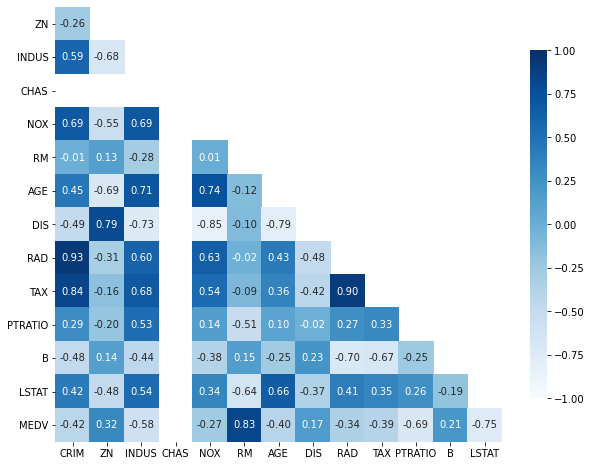

In [15]:
import seaborn as sb
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8))
# mask
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
# plot heatmap
sb.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='Blues',
           vmin=-1, vmax=1, cbar_kws={"shrink": .8})
# yticks
plt.yticks(rotation=0)
plt.show()

In [16]:
train_filepaths

['datasets\\housing\\my_train_00.csv',
 'datasets\\housing\\my_train_01.csv',
 'datasets\\housing\\my_train_02.csv',
 'datasets\\housing\\my_train_03.csv',
 'datasets\\housing\\my_train_04.csv',
 'datasets\\housing\\my_train_05.csv',
 'datasets\\housing\\my_train_06.csv',
 'datasets\\housing\\my_train_07.csv',
 'datasets\\housing\\my_train_08.csv',
 'datasets\\housing\\my_train_09.csv',
 'datasets\\housing\\my_train_10.csv',
 'datasets\\housing\\my_train_11.csv',
 'datasets\\housing\\my_train_12.csv',
 'datasets\\housing\\my_train_13.csv',
 'datasets\\housing\\my_train_14.csv',
 'datasets\\housing\\my_train_15.csv',
 'datasets\\housing\\my_train_16.csv',
 'datasets\\housing\\my_train_17.csv',
 'datasets\\housing\\my_train_18.csv',
 'datasets\\housing\\my_train_19.csv']

## Model Creation

In [17]:
from keras.losses import mean_squared_error
import tensorflow.keras.backend as K

## Model 1(Initial Model) - one hidden layer, Adam as optimizer and epoch =1500, RMSE: 2.75 from test data 

In [18]:
model = Sequential()
model.add(Dense(128, input_shape=(13, ), activation='relu', name='dense_1'))
model.add(Dense(64, activation='relu', name='dense_2'))
model.add(Dense(1, activation='linear', name='dense_output'))
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1792      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_output (Dense)         (None, 1)                 65        
Total params: 10,113
Trainable params: 10,113
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(X_train_full, y_train_full, epochs=1500, validation_split=0.05)

Epoch 1/1500
11/11 [==============================] - 0s 17ms/step - loss: 210.6608 - root_mean_squared_error: 14.5142 - val_loss: 67.6046 - val_root_mean_squared_error: 8.2222
Epoch 2/1500
11/11 [==============================] - 0s 3ms/step - loss: 111.6657 - root_mean_squared_error: 10.5672 - val_loss: 67.6552 - val_root_mean_squared_error: 8.2253
Epoch 3/1500
11/11 [==============================] - 0s 3ms/step - loss: 86.4441 - root_mean_squared_error: 9.2975 - val_loss: 41.2670 - val_root_mean_squared_error: 6.4239
Epoch 4/1500
11/11 [==============================] - 0s 3ms/step - loss: 81.0999 - root_mean_squared_error: 9.0056 - val_loss: 34.6754 - val_root_mean_squared_error: 5.8886
Epoch 5/1500
11/11 [==============================] - 0s 3ms/step - loss: 66.2331 - root_mean_squared_error: 8.1384 - val_loss: 26.2588 - val_root_mean_squared_error: 5.1243
Epoch 6/1500
11/11 [==============================] - 0s 3ms/step - loss: 60.8836 - root_mean_squared_error: 7.8028 - val_los

Epoch 48/1500
11/11 [==============================] - 0s 3ms/step - loss: 31.9874 - root_mean_squared_error: 5.6557 - val_loss: 6.6508 - val_root_mean_squared_error: 2.5789
Epoch 49/1500
11/11 [==============================] - 0s 3ms/step - loss: 30.7123 - root_mean_squared_error: 5.5419 - val_loss: 4.9776 - val_root_mean_squared_error: 2.2311
Epoch 50/1500
11/11 [==============================] - 0s 3ms/step - loss: 28.3619 - root_mean_squared_error: 5.3256 - val_loss: 5.1321 - val_root_mean_squared_error: 2.2654
Epoch 51/1500
11/11 [==============================] - 0s 3ms/step - loss: 30.8556 - root_mean_squared_error: 5.5548 - val_loss: 4.3543 - val_root_mean_squared_error: 2.0867
Epoch 52/1500
11/11 [==============================] - 0s 3ms/step - loss: 34.7846 - root_mean_squared_error: 5.8978 - val_loss: 5.7385 - val_root_mean_squared_error: 2.3955
Epoch 53/1500
11/11 [==============================] - 0s 3ms/step - loss: 29.1456 - root_mean_squared_error: 5.3987 - val_loss: 8

11/11 [==============================] - 0s 3ms/step - loss: 22.3425 - root_mean_squared_error: 4.7268 - val_loss: 6.2490 - val_root_mean_squared_error: 2.4998
Epoch 96/1500
11/11 [==============================] - 0s 3ms/step - loss: 23.0546 - root_mean_squared_error: 4.8015 - val_loss: 5.8227 - val_root_mean_squared_error: 2.4130
Epoch 97/1500
11/11 [==============================] - 0s 3ms/step - loss: 21.6362 - root_mean_squared_error: 4.6515 - val_loss: 5.3243 - val_root_mean_squared_error: 2.3074
Epoch 98/1500
11/11 [==============================] - 0s 3ms/step - loss: 26.2587 - root_mean_squared_error: 5.1243 - val_loss: 8.1264 - val_root_mean_squared_error: 2.8507
Epoch 99/1500
11/11 [==============================] - 0s 3ms/step - loss: 28.4305 - root_mean_squared_error: 5.3320 - val_loss: 9.4603 - val_root_mean_squared_error: 3.0758
Epoch 100/1500
11/11 [==============================] - 0s 3ms/step - loss: 24.1919 - root_mean_squared_error: 4.9185 - val_loss: 9.9277 - val_r

Epoch 142/1500
11/11 [==============================] - 0s 3ms/step - loss: 21.9421 - root_mean_squared_error: 4.6842 - val_loss: 13.5711 - val_root_mean_squared_error: 3.6839
Epoch 143/1500
11/11 [==============================] - 0s 3ms/step - loss: 24.5844 - root_mean_squared_error: 4.9583 - val_loss: 11.5383 - val_root_mean_squared_error: 3.3968
Epoch 144/1500
11/11 [==============================] - 0s 3ms/step - loss: 24.5429 - root_mean_squared_error: 4.9541 - val_loss: 6.1934 - val_root_mean_squared_error: 2.4887
Epoch 145/1500
11/11 [==============================] - 0s 3ms/step - loss: 25.8189 - root_mean_squared_error: 5.0812 - val_loss: 11.7375 - val_root_mean_squared_error: 3.4260
Epoch 146/1500
11/11 [==============================] - 0s 3ms/step - loss: 25.5898 - root_mean_squared_error: 5.0586 - val_loss: 17.5553 - val_root_mean_squared_error: 4.1899
Epoch 147/1500
11/11 [==============================] - 0s 3ms/step - loss: 20.3086 - root_mean_squared_error: 4.5065 - v

Epoch 189/1500
11/11 [==============================] - 0s 3ms/step - loss: 16.4646 - root_mean_squared_error: 4.0577 - val_loss: 6.3793 - val_root_mean_squared_error: 2.5257
Epoch 190/1500
11/11 [==============================] - 0s 3ms/step - loss: 14.5561 - root_mean_squared_error: 3.8152 - val_loss: 7.7929 - val_root_mean_squared_error: 2.7916
Epoch 191/1500
11/11 [==============================] - 0s 3ms/step - loss: 14.6991 - root_mean_squared_error: 3.8339 - val_loss: 8.7162 - val_root_mean_squared_error: 2.9523
Epoch 192/1500
11/11 [==============================] - 0s 3ms/step - loss: 14.3913 - root_mean_squared_error: 3.7936 - val_loss: 6.3726 - val_root_mean_squared_error: 2.5244
Epoch 193/1500
11/11 [==============================] - 0s 3ms/step - loss: 13.9425 - root_mean_squared_error: 3.7340 - val_loss: 10.7571 - val_root_mean_squared_error: 3.2798
Epoch 194/1500
11/11 [==============================] - 0s 3ms/step - loss: 16.2347 - root_mean_squared_error: 4.0292 - val_

Epoch 236/1500
11/11 [==============================] - 0s 3ms/step - loss: 16.3088 - root_mean_squared_error: 4.0384 - val_loss: 6.9699 - val_root_mean_squared_error: 2.6401
Epoch 237/1500
11/11 [==============================] - 0s 3ms/step - loss: 15.0354 - root_mean_squared_error: 3.8775 - val_loss: 8.9350 - val_root_mean_squared_error: 2.9892
Epoch 238/1500
11/11 [==============================] - 0s 3ms/step - loss: 14.1862 - root_mean_squared_error: 3.7665 - val_loss: 7.5009 - val_root_mean_squared_error: 2.7388
Epoch 239/1500
11/11 [==============================] - 0s 3ms/step - loss: 12.6878 - root_mean_squared_error: 3.5620 - val_loss: 7.5092 - val_root_mean_squared_error: 2.7403
Epoch 240/1500
11/11 [==============================] - 0s 3ms/step - loss: 14.4034 - root_mean_squared_error: 3.7952 - val_loss: 5.1302 - val_root_mean_squared_error: 2.2650
Epoch 241/1500
11/11 [==============================] - 0s 3ms/step - loss: 12.7201 - root_mean_squared_error: 3.5665 - val_l

Epoch 283/1500
11/11 [==============================] - 0s 3ms/step - loss: 12.6922 - root_mean_squared_error: 3.5626 - val_loss: 4.7795 - val_root_mean_squared_error: 2.1862
Epoch 284/1500
11/11 [==============================] - 0s 3ms/step - loss: 11.1391 - root_mean_squared_error: 3.3375 - val_loss: 7.8465 - val_root_mean_squared_error: 2.8012
Epoch 285/1500
11/11 [==============================] - 0s 3ms/step - loss: 12.4258 - root_mean_squared_error: 3.5250 - val_loss: 6.6547 - val_root_mean_squared_error: 2.5797
Epoch 286/1500
11/11 [==============================] - 0s 3ms/step - loss: 12.2843 - root_mean_squared_error: 3.5049 - val_loss: 5.8331 - val_root_mean_squared_error: 2.4152
Epoch 287/1500
11/11 [==============================] - 0s 3ms/step - loss: 14.7611 - root_mean_squared_error: 3.8420 - val_loss: 11.9684 - val_root_mean_squared_error: 3.4595
Epoch 288/1500
11/11 [==============================] - 0s 3ms/step - loss: 15.8619 - root_mean_squared_error: 3.9827 - val_

Epoch 330/1500
11/11 [==============================] - 0s 3ms/step - loss: 11.9357 - root_mean_squared_error: 3.4548 - val_loss: 6.8505 - val_root_mean_squared_error: 2.6173
Epoch 331/1500
11/11 [==============================] - 0s 3ms/step - loss: 10.0338 - root_mean_squared_error: 3.1676 - val_loss: 4.9041 - val_root_mean_squared_error: 2.2145
Epoch 332/1500
11/11 [==============================] - 0s 3ms/step - loss: 9.6924 - root_mean_squared_error: 3.1133 - val_loss: 6.5910 - val_root_mean_squared_error: 2.5673
Epoch 333/1500
11/11 [==============================] - 0s 3ms/step - loss: 9.2550 - root_mean_squared_error: 3.0422 - val_loss: 5.1148 - val_root_mean_squared_error: 2.2616
Epoch 334/1500
11/11 [==============================] - 0s 3ms/step - loss: 11.1914 - root_mean_squared_error: 3.3454 - val_loss: 4.4983 - val_root_mean_squared_error: 2.1209
Epoch 335/1500
11/11 [==============================] - 0s 3ms/step - loss: 10.5918 - root_mean_squared_error: 3.2545 - val_los

Epoch 377/1500
11/11 [==============================] - 0s 3ms/step - loss: 11.8956 - root_mean_squared_error: 3.4490 - val_loss: 8.6444 - val_root_mean_squared_error: 2.9401
Epoch 378/1500
11/11 [==============================] - 0s 3ms/step - loss: 12.4288 - root_mean_squared_error: 3.5255 - val_loss: 10.0550 - val_root_mean_squared_error: 3.1710
Epoch 379/1500
11/11 [==============================] - 0s 3ms/step - loss: 12.9643 - root_mean_squared_error: 3.6006 - val_loss: 10.5248 - val_root_mean_squared_error: 3.2442
Epoch 380/1500
11/11 [==============================] - 0s 3ms/step - loss: 11.3790 - root_mean_squared_error: 3.3733 - val_loss: 6.8283 - val_root_mean_squared_error: 2.6131
Epoch 381/1500
11/11 [==============================] - 0s 3ms/step - loss: 10.5688 - root_mean_squared_error: 3.2510 - val_loss: 4.9814 - val_root_mean_squared_error: 2.2319
Epoch 382/1500
11/11 [==============================] - 0s 3ms/step - loss: 10.2201 - root_mean_squared_error: 3.1969 - val

Epoch 424/1500
11/11 [==============================] - 0s 3ms/step - loss: 9.1224 - root_mean_squared_error: 3.0203 - val_loss: 5.8600 - val_root_mean_squared_error: 2.4207
Epoch 425/1500
11/11 [==============================] - 0s 3ms/step - loss: 9.5555 - root_mean_squared_error: 3.0912 - val_loss: 5.9710 - val_root_mean_squared_error: 2.4436
Epoch 426/1500
11/11 [==============================] - 0s 3ms/step - loss: 12.2840 - root_mean_squared_error: 3.5049 - val_loss: 6.9509 - val_root_mean_squared_error: 2.6365
Epoch 427/1500
11/11 [==============================] - 0s 3ms/step - loss: 10.3981 - root_mean_squared_error: 3.2246 - val_loss: 4.7935 - val_root_mean_squared_error: 2.1894
Epoch 428/1500
11/11 [==============================] - 0s 3ms/step - loss: 10.4070 - root_mean_squared_error: 3.2260 - val_loss: 12.6059 - val_root_mean_squared_error: 3.5505
Epoch 429/1500
11/11 [==============================] - 0s 3ms/step - loss: 12.1406 - root_mean_squared_error: 3.4843 - val_lo

Epoch 471/1500
11/11 [==============================] - 0s 4ms/step - loss: 8.9647 - root_mean_squared_error: 2.9941 - val_loss: 8.3490 - val_root_mean_squared_error: 2.8895
Epoch 472/1500
11/11 [==============================] - 0s 3ms/step - loss: 9.8798 - root_mean_squared_error: 3.1432 - val_loss: 6.7118 - val_root_mean_squared_error: 2.5907
Epoch 473/1500
11/11 [==============================] - 0s 3ms/step - loss: 10.2975 - root_mean_squared_error: 3.2090 - val_loss: 6.0822 - val_root_mean_squared_error: 2.4662
Epoch 474/1500
11/11 [==============================] - 0s 2ms/step - loss: 8.3322 - root_mean_squared_error: 2.8866 - val_loss: 5.3728 - val_root_mean_squared_error: 2.3179
Epoch 475/1500
11/11 [==============================] - 0s 3ms/step - loss: 8.4796 - root_mean_squared_error: 2.9120 - val_loss: 5.6206 - val_root_mean_squared_error: 2.3708
Epoch 476/1500
11/11 [==============================] - 0s 3ms/step - loss: 8.7598 - root_mean_squared_error: 2.9597 - val_loss: 

11/11 [==============================] - 0s 3ms/step - loss: 8.9714 - root_mean_squared_error: 2.9952 - val_loss: 5.8982 - val_root_mean_squared_error: 2.4286
Epoch 519/1500
11/11 [==============================] - 0s 3ms/step - loss: 9.4098 - root_mean_squared_error: 3.0675 - val_loss: 8.4089 - val_root_mean_squared_error: 2.8998
Epoch 520/1500
11/11 [==============================] - 0s 3ms/step - loss: 8.3115 - root_mean_squared_error: 2.8830 - val_loss: 7.3720 - val_root_mean_squared_error: 2.7151
Epoch 521/1500
11/11 [==============================] - 0s 3ms/step - loss: 8.1712 - root_mean_squared_error: 2.8585 - val_loss: 6.0376 - val_root_mean_squared_error: 2.4571
Epoch 522/1500
11/11 [==============================] - 0s 3ms/step - loss: 8.2583 - root_mean_squared_error: 2.8737 - val_loss: 4.5550 - val_root_mean_squared_error: 2.1342
Epoch 523/1500
11/11 [==============================] - 0s 2ms/step - loss: 8.6016 - root_mean_squared_error: 2.9329 - val_loss: 6.5881 - val_roo

11/11 [==============================] - 0s 3ms/step - loss: 7.9901 - root_mean_squared_error: 2.8267 - val_loss: 6.8977 - val_root_mean_squared_error: 2.6264
Epoch 566/1500
11/11 [==============================] - 0s 3ms/step - loss: 7.9837 - root_mean_squared_error: 2.8255 - val_loss: 4.9826 - val_root_mean_squared_error: 2.2322
Epoch 567/1500
11/11 [==============================] - 0s 3ms/step - loss: 8.7003 - root_mean_squared_error: 2.9496 - val_loss: 6.2708 - val_root_mean_squared_error: 2.5041
Epoch 568/1500
11/11 [==============================] - 0s 3ms/step - loss: 7.9609 - root_mean_squared_error: 2.8215 - val_loss: 9.7206 - val_root_mean_squared_error: 3.1178
Epoch 569/1500
11/11 [==============================] - 0s 3ms/step - loss: 7.7783 - root_mean_squared_error: 2.7890 - val_loss: 6.2405 - val_root_mean_squared_error: 2.4981
Epoch 570/1500
11/11 [==============================] - 0s 3ms/step - loss: 7.9932 - root_mean_squared_error: 2.8272 - val_loss: 6.1060 - val_roo

11/11 [==============================] - 0s 3ms/step - loss: 7.3775 - root_mean_squared_error: 2.7162 - val_loss: 5.5819 - val_root_mean_squared_error: 2.3626
Epoch 613/1500
11/11 [==============================] - 0s 3ms/step - loss: 6.9137 - root_mean_squared_error: 2.6294 - val_loss: 5.3330 - val_root_mean_squared_error: 2.3093
Epoch 614/1500
11/11 [==============================] - 0s 3ms/step - loss: 6.8759 - root_mean_squared_error: 2.6222 - val_loss: 6.2413 - val_root_mean_squared_error: 2.4983
Epoch 615/1500
11/11 [==============================] - 0s 3ms/step - loss: 7.6784 - root_mean_squared_error: 2.7710 - val_loss: 5.3628 - val_root_mean_squared_error: 2.3158
Epoch 616/1500
11/11 [==============================] - 0s 3ms/step - loss: 8.9288 - root_mean_squared_error: 2.9881 - val_loss: 10.3049 - val_root_mean_squared_error: 3.2101
Epoch 617/1500
11/11 [==============================] - 0s 3ms/step - loss: 9.3617 - root_mean_squared_error: 3.0597 - val_loss: 8.6496 - val_ro

11/11 [==============================] - 0s 3ms/step - loss: 8.6130 - root_mean_squared_error: 2.9348 - val_loss: 8.3759 - val_root_mean_squared_error: 2.8941
Epoch 660/1500
11/11 [==============================] - 0s 3ms/step - loss: 7.7997 - root_mean_squared_error: 2.7928 - val_loss: 5.9391 - val_root_mean_squared_error: 2.4370
Epoch 661/1500
11/11 [==============================] - 0s 3ms/step - loss: 9.1127 - root_mean_squared_error: 3.0187 - val_loss: 6.4167 - val_root_mean_squared_error: 2.5331
Epoch 662/1500
11/11 [==============================] - 0s 3ms/step - loss: 8.5610 - root_mean_squared_error: 2.9259 - val_loss: 5.6655 - val_root_mean_squared_error: 2.3802
Epoch 663/1500
11/11 [==============================] - 0s 3ms/step - loss: 7.1006 - root_mean_squared_error: 2.6647 - val_loss: 9.7210 - val_root_mean_squared_error: 3.1179
Epoch 664/1500
11/11 [==============================] - 0s 3ms/step - loss: 8.9111 - root_mean_squared_error: 2.9852 - val_loss: 6.4939 - val_roo

11/11 [==============================] - 0s 3ms/step - loss: 10.1113 - root_mean_squared_error: 3.1798 - val_loss: 12.4094 - val_root_mean_squared_error: 3.5227
Epoch 707/1500
11/11 [==============================] - 0s 3ms/step - loss: 9.0766 - root_mean_squared_error: 3.0127 - val_loss: 6.6174 - val_root_mean_squared_error: 2.5724
Epoch 708/1500
11/11 [==============================] - 0s 3ms/step - loss: 6.8129 - root_mean_squared_error: 2.6102 - val_loss: 4.7512 - val_root_mean_squared_error: 2.1797
Epoch 709/1500
11/11 [==============================] - 0s 3ms/step - loss: 6.9536 - root_mean_squared_error: 2.6370 - val_loss: 5.5968 - val_root_mean_squared_error: 2.3658
Epoch 710/1500
11/11 [==============================] - 0s 3ms/step - loss: 7.5314 - root_mean_squared_error: 2.7443 - val_loss: 15.8798 - val_root_mean_squared_error: 3.9849
Epoch 711/1500
11/11 [==============================] - 0s 3ms/step - loss: 9.1690 - root_mean_squared_error: 3.0280 - val_loss: 10.5067 - val

11/11 [==============================] - 0s 3ms/step - loss: 6.4722 - root_mean_squared_error: 2.5441 - val_loss: 5.1808 - val_root_mean_squared_error: 2.2761
Epoch 754/1500
11/11 [==============================] - 0s 3ms/step - loss: 5.7088 - root_mean_squared_error: 2.3893 - val_loss: 5.4500 - val_root_mean_squared_error: 2.3345
Epoch 755/1500
11/11 [==============================] - 0s 3ms/step - loss: 6.6098 - root_mean_squared_error: 2.5710 - val_loss: 6.4353 - val_root_mean_squared_error: 2.5368
Epoch 756/1500
11/11 [==============================] - 0s 3ms/step - loss: 6.3772 - root_mean_squared_error: 2.5253 - val_loss: 7.4433 - val_root_mean_squared_error: 2.7282
Epoch 757/1500
11/11 [==============================] - 0s 3ms/step - loss: 6.3227 - root_mean_squared_error: 2.5145 - val_loss: 5.6895 - val_root_mean_squared_error: 2.3853
Epoch 758/1500
11/11 [==============================] - 0s 2ms/step - loss: 5.5295 - root_mean_squared_error: 2.3515 - val_loss: 5.1473 - val_roo

11/11 [==============================] - 0s 3ms/step - loss: 6.7706 - root_mean_squared_error: 2.6020 - val_loss: 7.3310 - val_root_mean_squared_error: 2.7076
Epoch 801/1500
11/11 [==============================] - 0s 3ms/step - loss: 7.4039 - root_mean_squared_error: 2.7210 - val_loss: 8.9403 - val_root_mean_squared_error: 2.9900
Epoch 802/1500
11/11 [==============================] - 0s 3ms/step - loss: 8.1914 - root_mean_squared_error: 2.8621 - val_loss: 7.5197 - val_root_mean_squared_error: 2.7422
Epoch 803/1500
11/11 [==============================] - 0s 3ms/step - loss: 9.7825 - root_mean_squared_error: 3.1277 - val_loss: 7.1082 - val_root_mean_squared_error: 2.6661
Epoch 804/1500
11/11 [==============================] - 0s 3ms/step - loss: 10.1240 - root_mean_squared_error: 3.1818 - val_loss: 7.2735 - val_root_mean_squared_error: 2.6969
Epoch 805/1500
11/11 [==============================] - 0s 3ms/step - loss: 9.1234 - root_mean_squared_error: 3.0205 - val_loss: 9.4403 - val_ro

11/11 [==============================] - 0s 3ms/step - loss: 6.0030 - root_mean_squared_error: 2.4501 - val_loss: 5.9422 - val_root_mean_squared_error: 2.4377
Epoch 848/1500
11/11 [==============================] - 0s 3ms/step - loss: 6.6563 - root_mean_squared_error: 2.5800 - val_loss: 5.8040 - val_root_mean_squared_error: 2.4092
Epoch 849/1500
11/11 [==============================] - 0s 3ms/step - loss: 6.3781 - root_mean_squared_error: 2.5255 - val_loss: 5.6514 - val_root_mean_squared_error: 2.3773
Epoch 850/1500
11/11 [==============================] - 0s 3ms/step - loss: 6.4180 - root_mean_squared_error: 2.5334 - val_loss: 7.2579 - val_root_mean_squared_error: 2.6941
Epoch 851/1500
11/11 [==============================] - 0s 3ms/step - loss: 10.1517 - root_mean_squared_error: 3.1862 - val_loss: 12.7089 - val_root_mean_squared_error: 3.5649
Epoch 852/1500
11/11 [==============================] - 0s 3ms/step - loss: 10.3238 - root_mean_squared_error: 3.2131 - val_loss: 5.8263 - val_

11/11 [==============================] - 0s 3ms/step - loss: 5.0248 - root_mean_squared_error: 2.2416 - val_loss: 4.3911 - val_root_mean_squared_error: 2.0955
Epoch 895/1500
11/11 [==============================] - 0s 3ms/step - loss: 6.0199 - root_mean_squared_error: 2.4535 - val_loss: 5.0477 - val_root_mean_squared_error: 2.2467
Epoch 896/1500
11/11 [==============================] - 0s 3ms/step - loss: 7.2576 - root_mean_squared_error: 2.6940 - val_loss: 4.8019 - val_root_mean_squared_error: 2.1913
Epoch 897/1500
11/11 [==============================] - 0s 3ms/step - loss: 6.2090 - root_mean_squared_error: 2.4918 - val_loss: 4.6449 - val_root_mean_squared_error: 2.1552
Epoch 898/1500
11/11 [==============================] - 0s 3ms/step - loss: 5.2179 - root_mean_squared_error: 2.2843 - val_loss: 5.4275 - val_root_mean_squared_error: 2.3297
Epoch 899/1500
11/11 [==============================] - 0s 3ms/step - loss: 5.9611 - root_mean_squared_error: 2.4415 - val_loss: 5.6074 - val_roo

11/11 [==============================] - 0s 3ms/step - loss: 5.5591 - root_mean_squared_error: 2.3578 - val_loss: 4.2026 - val_root_mean_squared_error: 2.0500
Epoch 942/1500
11/11 [==============================] - 0s 3ms/step - loss: 4.8492 - root_mean_squared_error: 2.2021 - val_loss: 8.4952 - val_root_mean_squared_error: 2.9147
Epoch 943/1500
11/11 [==============================] - 0s 3ms/step - loss: 5.6838 - root_mean_squared_error: 2.3841 - val_loss: 7.4406 - val_root_mean_squared_error: 2.7278
Epoch 944/1500
11/11 [==============================] - 0s 3ms/step - loss: 4.9224 - root_mean_squared_error: 2.2187 - val_loss: 4.7933 - val_root_mean_squared_error: 2.1894
Epoch 945/1500
11/11 [==============================] - 0s 3ms/step - loss: 5.0951 - root_mean_squared_error: 2.2572 - val_loss: 4.6466 - val_root_mean_squared_error: 2.1556
Epoch 946/1500
11/11 [==============================] - 0s 3ms/step - loss: 4.6369 - root_mean_squared_error: 2.1533 - val_loss: 4.4363 - val_roo

11/11 [==============================] - 0s 3ms/step - loss: 4.6858 - root_mean_squared_error: 2.1647 - val_loss: 4.2735 - val_root_mean_squared_error: 2.0673
Epoch 989/1500
11/11 [==============================] - 0s 3ms/step - loss: 4.1756 - root_mean_squared_error: 2.0434 - val_loss: 4.0812 - val_root_mean_squared_error: 2.0202
Epoch 990/1500
11/11 [==============================] - 0s 3ms/step - loss: 4.8762 - root_mean_squared_error: 2.2082 - val_loss: 6.8380 - val_root_mean_squared_error: 2.6150
Epoch 991/1500
11/11 [==============================] - 0s 3ms/step - loss: 4.5571 - root_mean_squared_error: 2.1347 - val_loss: 5.3520 - val_root_mean_squared_error: 2.3134
Epoch 992/1500
11/11 [==============================] - 0s 3ms/step - loss: 4.2004 - root_mean_squared_error: 2.0495 - val_loss: 4.8148 - val_root_mean_squared_error: 2.1943
Epoch 993/1500
11/11 [==============================] - 0s 3ms/step - loss: 5.3112 - root_mean_squared_error: 2.3046 - val_loss: 4.0171 - val_roo

Epoch 1035/1500
11/11 [==============================] - 0s 3ms/step - loss: 6.1911 - root_mean_squared_error: 2.4882 - val_loss: 5.9709 - val_root_mean_squared_error: 2.4435
Epoch 1036/1500
11/11 [==============================] - 0s 3ms/step - loss: 5.0505 - root_mean_squared_error: 2.2473 - val_loss: 4.1565 - val_root_mean_squared_error: 2.0387
Epoch 1037/1500
11/11 [==============================] - 0s 3ms/step - loss: 4.2571 - root_mean_squared_error: 2.0633 - val_loss: 5.1760 - val_root_mean_squared_error: 2.2751
Epoch 1038/1500
11/11 [==============================] - 0s 3ms/step - loss: 4.9311 - root_mean_squared_error: 2.2206 - val_loss: 3.4338 - val_root_mean_squared_error: 1.8531
Epoch 1039/1500
11/11 [==============================] - 0s 3ms/step - loss: 4.3517 - root_mean_squared_error: 2.0861 - val_loss: 4.5440 - val_root_mean_squared_error: 2.1317
Epoch 1040/1500
11/11 [==============================] - 0s 3ms/step - loss: 4.4961 - root_mean_squared_error: 2.1204 - val_l

Epoch 1082/1500
11/11 [==============================] - 0s 3ms/step - loss: 5.9694 - root_mean_squared_error: 2.4432 - val_loss: 3.9756 - val_root_mean_squared_error: 1.9939
Epoch 1083/1500
11/11 [==============================] - 0s 3ms/step - loss: 4.5619 - root_mean_squared_error: 2.1359 - val_loss: 5.8194 - val_root_mean_squared_error: 2.4123
Epoch 1084/1500
11/11 [==============================] - 0s 3ms/step - loss: 4.3009 - root_mean_squared_error: 2.0739 - val_loss: 5.9477 - val_root_mean_squared_error: 2.4388
Epoch 1085/1500
11/11 [==============================] - 0s 3ms/step - loss: 4.5476 - root_mean_squared_error: 2.1325 - val_loss: 5.1335 - val_root_mean_squared_error: 2.2657
Epoch 1086/1500
11/11 [==============================] - 0s 3ms/step - loss: 6.8465 - root_mean_squared_error: 2.6166 - val_loss: 11.7215 - val_root_mean_squared_error: 3.4237
Epoch 1087/1500
11/11 [==============================] - 0s 3ms/step - loss: 5.5453 - root_mean_squared_error: 2.3548 - val_

Epoch 1129/1500
11/11 [==============================] - 0s 3ms/step - loss: 5.4227 - root_mean_squared_error: 2.3287 - val_loss: 15.0733 - val_root_mean_squared_error: 3.8824
Epoch 1130/1500
11/11 [==============================] - 0s 3ms/step - loss: 5.9505 - root_mean_squared_error: 2.4394 - val_loss: 4.1459 - val_root_mean_squared_error: 2.0362
Epoch 1131/1500
11/11 [==============================] - 0s 4ms/step - loss: 4.5505 - root_mean_squared_error: 2.1332 - val_loss: 3.3915 - val_root_mean_squared_error: 1.8416
Epoch 1132/1500
11/11 [==============================] - 0s 4ms/step - loss: 4.2152 - root_mean_squared_error: 2.0531 - val_loss: 4.1973 - val_root_mean_squared_error: 2.0487
Epoch 1133/1500
11/11 [==============================] - 0s 3ms/step - loss: 4.4127 - root_mean_squared_error: 2.1006 - val_loss: 7.2452 - val_root_mean_squared_error: 2.6917
Epoch 1134/1500
11/11 [==============================] - 0s 3ms/step - loss: 4.6682 - root_mean_squared_error: 2.1606 - val_

Epoch 1176/1500
11/11 [==============================] - 0s 3ms/step - loss: 4.3078 - root_mean_squared_error: 2.0755 - val_loss: 4.0134 - val_root_mean_squared_error: 2.0033
Epoch 1177/1500
11/11 [==============================] - 0s 3ms/step - loss: 4.1511 - root_mean_squared_error: 2.0374 - val_loss: 11.0383 - val_root_mean_squared_error: 3.3224
Epoch 1178/1500
11/11 [==============================] - 0s 3ms/step - loss: 5.0141 - root_mean_squared_error: 2.2392 - val_loss: 6.6917 - val_root_mean_squared_error: 2.5868
Epoch 1179/1500
11/11 [==============================] - 0s 3ms/step - loss: 4.4800 - root_mean_squared_error: 2.1166 - val_loss: 3.2191 - val_root_mean_squared_error: 1.7942
Epoch 1180/1500
11/11 [==============================] - 0s 3ms/step - loss: 3.8318 - root_mean_squared_error: 1.9575 - val_loss: 4.0942 - val_root_mean_squared_error: 2.0234
Epoch 1181/1500
11/11 [==============================] - 0s 3ms/step - loss: 4.2650 - root_mean_squared_error: 2.0652 - val_

Epoch 1223/1500
11/11 [==============================] - 0s 3ms/step - loss: 3.3604 - root_mean_squared_error: 1.8332 - val_loss: 4.2924 - val_root_mean_squared_error: 2.0718
Epoch 1224/1500
11/11 [==============================] - 0s 3ms/step - loss: 3.5060 - root_mean_squared_error: 1.8724 - val_loss: 4.5842 - val_root_mean_squared_error: 2.1411
Epoch 1225/1500
11/11 [==============================] - 0s 3ms/step - loss: 4.6162 - root_mean_squared_error: 2.1485 - val_loss: 2.7380 - val_root_mean_squared_error: 1.6547
Epoch 1226/1500
11/11 [==============================] - 0s 3ms/step - loss: 3.3656 - root_mean_squared_error: 1.8345 - val_loss: 4.2443 - val_root_mean_squared_error: 2.0602
Epoch 1227/1500
11/11 [==============================] - 0s 3ms/step - loss: 5.3422 - root_mean_squared_error: 2.3113 - val_loss: 4.3143 - val_root_mean_squared_error: 2.0771
Epoch 1228/1500
11/11 [==============================] - 0s 3ms/step - loss: 5.2572 - root_mean_squared_error: 2.2929 - val_l

Epoch 1270/1500
11/11 [==============================] - 0s 3ms/step - loss: 3.8348 - root_mean_squared_error: 1.9583 - val_loss: 5.3584 - val_root_mean_squared_error: 2.3148
Epoch 1271/1500
11/11 [==============================] - 0s 3ms/step - loss: 3.7074 - root_mean_squared_error: 1.9255 - val_loss: 7.4388 - val_root_mean_squared_error: 2.7274
Epoch 1272/1500
11/11 [==============================] - 0s 3ms/step - loss: 4.7174 - root_mean_squared_error: 2.1720 - val_loss: 7.1028 - val_root_mean_squared_error: 2.6651
Epoch 1273/1500
11/11 [==============================] - 0s 3ms/step - loss: 4.4198 - root_mean_squared_error: 2.1023 - val_loss: 3.8861 - val_root_mean_squared_error: 1.9713
Epoch 1274/1500
11/11 [==============================] - 0s 3ms/step - loss: 4.4306 - root_mean_squared_error: 2.1049 - val_loss: 4.7682 - val_root_mean_squared_error: 2.1836
Epoch 1275/1500
11/11 [==============================] - 0s 3ms/step - loss: 3.4905 - root_mean_squared_error: 1.8683 - val_l

Epoch 1317/1500
11/11 [==============================] - 0s 3ms/step - loss: 3.6671 - root_mean_squared_error: 1.9150 - val_loss: 5.4482 - val_root_mean_squared_error: 2.3341
Epoch 1318/1500
11/11 [==============================] - 0s 3ms/step - loss: 3.1107 - root_mean_squared_error: 1.7637 - val_loss: 4.8274 - val_root_mean_squared_error: 2.1971
Epoch 1319/1500
11/11 [==============================] - 0s 3ms/step - loss: 3.1923 - root_mean_squared_error: 1.7867 - val_loss: 4.2272 - val_root_mean_squared_error: 2.0560
Epoch 1320/1500
11/11 [==============================] - 0s 3ms/step - loss: 3.3093 - root_mean_squared_error: 1.8191 - val_loss: 5.0571 - val_root_mean_squared_error: 2.2488
Epoch 1321/1500
11/11 [==============================] - 0s 3ms/step - loss: 2.8306 - root_mean_squared_error: 1.6824 - val_loss: 5.0620 - val_root_mean_squared_error: 2.2499
Epoch 1322/1500
11/11 [==============================] - 0s 3ms/step - loss: 2.8565 - root_mean_squared_error: 1.6901 - val_l

Epoch 1364/1500
11/11 [==============================] - 0s 3ms/step - loss: 3.2803 - root_mean_squared_error: 1.8112 - val_loss: 4.0659 - val_root_mean_squared_error: 2.0164
Epoch 1365/1500
11/11 [==============================] - 0s 3ms/step - loss: 3.1215 - root_mean_squared_error: 1.7668 - val_loss: 6.1583 - val_root_mean_squared_error: 2.4816
Epoch 1366/1500
11/11 [==============================] - 0s 3ms/step - loss: 3.4337 - root_mean_squared_error: 1.8530 - val_loss: 4.2453 - val_root_mean_squared_error: 2.0604
Epoch 1367/1500
11/11 [==============================] - 0s 3ms/step - loss: 3.5753 - root_mean_squared_error: 1.8909 - val_loss: 4.4116 - val_root_mean_squared_error: 2.1004
Epoch 1368/1500
11/11 [==============================] - 0s 3ms/step - loss: 3.2678 - root_mean_squared_error: 1.8077 - val_loss: 3.9597 - val_root_mean_squared_error: 1.9899
Epoch 1369/1500
11/11 [==============================] - 0s 3ms/step - loss: 2.9604 - root_mean_squared_error: 1.7206 - val_l

Epoch 1411/1500
11/11 [==============================] - 0s 3ms/step - loss: 3.0867 - root_mean_squared_error: 1.7569 - val_loss: 3.5510 - val_root_mean_squared_error: 1.8844
Epoch 1412/1500
11/11 [==============================] - 0s 3ms/step - loss: 3.2022 - root_mean_squared_error: 1.7895 - val_loss: 3.8962 - val_root_mean_squared_error: 1.9739
Epoch 1413/1500
11/11 [==============================] - 0s 3ms/step - loss: 3.4754 - root_mean_squared_error: 1.8642 - val_loss: 4.0874 - val_root_mean_squared_error: 2.0217
Epoch 1414/1500
11/11 [==============================] - 0s 3ms/step - loss: 2.6635 - root_mean_squared_error: 1.6320 - val_loss: 3.8640 - val_root_mean_squared_error: 1.9657
Epoch 1415/1500
11/11 [==============================] - 0s 3ms/step - loss: 2.3098 - root_mean_squared_error: 1.5198 - val_loss: 3.1998 - val_root_mean_squared_error: 1.7888
Epoch 1416/1500
11/11 [==============================] - 0s 3ms/step - loss: 3.0553 - root_mean_squared_error: 1.7480 - val_l

Epoch 1458/1500
11/11 [==============================] - 0s 3ms/step - loss: 2.4242 - root_mean_squared_error: 1.5570 - val_loss: 3.6768 - val_root_mean_squared_error: 1.9175
Epoch 1459/1500
11/11 [==============================] - 0s 3ms/step - loss: 2.9867 - root_mean_squared_error: 1.7282 - val_loss: 4.3894 - val_root_mean_squared_error: 2.0951
Epoch 1460/1500
11/11 [==============================] - 0s 3ms/step - loss: 2.8873 - root_mean_squared_error: 1.6992 - val_loss: 4.3283 - val_root_mean_squared_error: 2.0804
Epoch 1461/1500
11/11 [==============================] - 0s 3ms/step - loss: 2.9956 - root_mean_squared_error: 1.7308 - val_loss: 3.4150 - val_root_mean_squared_error: 1.8480
Epoch 1462/1500
11/11 [==============================] - 0s 3ms/step - loss: 4.1423 - root_mean_squared_error: 2.0353 - val_loss: 4.5044 - val_root_mean_squared_error: 2.1224
Epoch 1463/1500
11/11 [==============================] - 0s 3ms/step - loss: 3.4400 - root_mean_squared_error: 1.8547 - val_l

## Evaluate model

In [20]:
root_mean_squared_error = model.evaluate(X_test, y_test)
print("Mean squared error on test data:", root_mean_squared_error)

2/2 [==============================] - 0s 982us/step - loss: 11.3032 - root_mean_squared_error: 3.3620
Mean squared error on test data: [11.303227424621582, 3.362027168273926]


## Model Visualization 

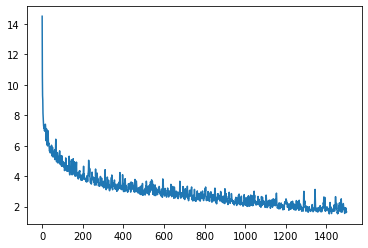

In [21]:
import matplotlib
import seaborn as sb
from matplotlib import pyplot as plt
plt.plot(history.history['root_mean_squared_error'])

## Hyperparameter Turnning

## Model 2: 2 hidden layers, optimizer: Adam  and epoch = 2000, RMSE = 2.04 from test data

## learning rate = 0.01

In [22]:
model = Sequential()
model.add(Dense(128, input_shape=(13, ), activation='relu', name='dense_1'))
model.add(Dense(64, activation='relu', name='dense_2'))
model.add(Dense(32, activation='relu', name='dense_3'))
model.add(Dense(1, activation='linear', name='dense_output'))
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer= opt,  loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1792      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_output (Dense)         (None, 1)                 33        
Total params: 12,161
Trainable params: 12,161
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.fit(X_train_full, y_train_full, epochs=2000, validation_split=0.05)

Epoch 1/2000
11/11 [==============================] - 0s 14ms/step - loss: 4235.7812 - root_mean_squared_error: 65.0829 - val_loss: 208.1491 - val_root_mean_squared_error: 14.4274
Epoch 2/2000
11/11 [==============================] - 0s 3ms/step - loss: 219.7860 - root_mean_squared_error: 14.8252 - val_loss: 77.5598 - val_root_mean_squared_error: 8.8068
Epoch 3/2000
11/11 [==============================] - 0s 3ms/step - loss: 111.1165 - root_mean_squared_error: 10.5412 - val_loss: 76.6153 - val_root_mean_squared_error: 8.7530
Epoch 4/2000
11/11 [==============================] - 0s 3ms/step - loss: 88.1743 - root_mean_squared_error: 9.3901 - val_loss: 35.1142 - val_root_mean_squared_error: 5.9257
Epoch 5/2000
11/11 [==============================] - 0s 3ms/step - loss: 67.6953 - root_mean_squared_error: 8.2277 - val_loss: 36.2383 - val_root_mean_squared_error: 6.0198
Epoch 6/2000
11/11 [==============================] - 0s 3ms/step - loss: 67.2378 - root_mean_squared_error: 8.1999 - va

Epoch 48/2000
11/11 [==============================] - 0s 3ms/step - loss: 25.6422 - root_mean_squared_error: 5.0638 - val_loss: 13.0393 - val_root_mean_squared_error: 3.6110
Epoch 49/2000
11/11 [==============================] - 0s 3ms/step - loss: 26.2592 - root_mean_squared_error: 5.1244 - val_loss: 9.5536 - val_root_mean_squared_error: 3.0909
Epoch 50/2000
11/11 [==============================] - 0s 3ms/step - loss: 22.2504 - root_mean_squared_error: 4.7170 - val_loss: 3.7503 - val_root_mean_squared_error: 1.9366
Epoch 51/2000
11/11 [==============================] - 0s 3ms/step - loss: 26.5088 - root_mean_squared_error: 5.1487 - val_loss: 2.6263 - val_root_mean_squared_error: 1.6206
Epoch 52/2000
11/11 [==============================] - 0s 2ms/step - loss: 25.9166 - root_mean_squared_error: 5.0908 - val_loss: 7.2818 - val_root_mean_squared_error: 2.6985
Epoch 53/2000
11/11 [==============================] - 0s 3ms/step - loss: 23.2129 - root_mean_squared_error: 4.8180 - val_loss: 

11/11 [==============================] - 0s 3ms/step - loss: 16.7579 - root_mean_squared_error: 4.0936 - val_loss: 9.2364 - val_root_mean_squared_error: 3.0391
Epoch 96/2000
11/11 [==============================] - 0s 3ms/step - loss: 16.2114 - root_mean_squared_error: 4.0263 - val_loss: 9.9154 - val_root_mean_squared_error: 3.1489
Epoch 97/2000
11/11 [==============================] - 0s 3ms/step - loss: 13.9176 - root_mean_squared_error: 3.7306 - val_loss: 10.2582 - val_root_mean_squared_error: 3.2028
Epoch 98/2000
11/11 [==============================] - 0s 3ms/step - loss: 24.0407 - root_mean_squared_error: 4.9031 - val_loss: 21.7888 - val_root_mean_squared_error: 4.6678
Epoch 99/2000
11/11 [==============================] - 0s 3ms/step - loss: 20.2016 - root_mean_squared_error: 4.4946 - val_loss: 12.4276 - val_root_mean_squared_error: 3.5253
Epoch 100/2000
11/11 [==============================] - 0s 3ms/step - loss: 17.2479 - root_mean_squared_error: 4.1531 - val_loss: 5.8103 - va

Epoch 142/2000
11/11 [==============================] - 0s 3ms/step - loss: 13.8961 - root_mean_squared_error: 3.7277 - val_loss: 7.1362 - val_root_mean_squared_error: 2.6714
Epoch 143/2000
11/11 [==============================] - 0s 3ms/step - loss: 13.5162 - root_mean_squared_error: 3.6764 - val_loss: 6.8200 - val_root_mean_squared_error: 2.6115
Epoch 144/2000
11/11 [==============================] - 0s 3ms/step - loss: 13.1124 - root_mean_squared_error: 3.6211 - val_loss: 11.6797 - val_root_mean_squared_error: 3.4176
Epoch 145/2000
11/11 [==============================] - 0s 3ms/step - loss: 16.4799 - root_mean_squared_error: 4.0595 - val_loss: 13.3752 - val_root_mean_squared_error: 3.6572
Epoch 146/2000
11/11 [==============================] - 0s 3ms/step - loss: 15.3446 - root_mean_squared_error: 3.9172 - val_loss: 19.8410 - val_root_mean_squared_error: 4.4543
Epoch 147/2000
11/11 [==============================] - 0s 3ms/step - loss: 16.6460 - root_mean_squared_error: 4.0799 - va

Epoch 189/2000
11/11 [==============================] - 0s 3ms/step - loss: 16.3046 - root_mean_squared_error: 4.0379 - val_loss: 8.2817 - val_root_mean_squared_error: 2.8778
Epoch 190/2000
11/11 [==============================] - 0s 3ms/step - loss: 11.8188 - root_mean_squared_error: 3.4378 - val_loss: 5.6324 - val_root_mean_squared_error: 2.3733
Epoch 191/2000
11/11 [==============================] - 0s 3ms/step - loss: 11.5597 - root_mean_squared_error: 3.3999 - val_loss: 6.2261 - val_root_mean_squared_error: 2.4952
Epoch 192/2000
11/11 [==============================] - 0s 3ms/step - loss: 14.2164 - root_mean_squared_error: 3.7705 - val_loss: 9.9572 - val_root_mean_squared_error: 3.1555
Epoch 193/2000
11/11 [==============================] - 0s 3ms/step - loss: 12.3059 - root_mean_squared_error: 3.5080 - val_loss: 7.2406 - val_root_mean_squared_error: 2.6908
Epoch 194/2000
11/11 [==============================] - 0s 3ms/step - loss: 12.8465 - root_mean_squared_error: 3.5842 - val_l

Epoch 236/2000
11/11 [==============================] - 0s 3ms/step - loss: 11.2187 - root_mean_squared_error: 3.3494 - val_loss: 4.0024 - val_root_mean_squared_error: 2.0006
Epoch 237/2000
11/11 [==============================] - 0s 3ms/step - loss: 11.7498 - root_mean_squared_error: 3.4278 - val_loss: 13.1470 - val_root_mean_squared_error: 3.6259
Epoch 238/2000
11/11 [==============================] - 0s 3ms/step - loss: 11.8499 - root_mean_squared_error: 3.4424 - val_loss: 7.4291 - val_root_mean_squared_error: 2.7256
Epoch 239/2000
11/11 [==============================] - 0s 3ms/step - loss: 10.7325 - root_mean_squared_error: 3.2761 - val_loss: 10.2918 - val_root_mean_squared_error: 3.2081
Epoch 240/2000
11/11 [==============================] - 0s 3ms/step - loss: 14.1390 - root_mean_squared_error: 3.7602 - val_loss: 9.7423 - val_root_mean_squared_error: 3.1213
Epoch 241/2000
11/11 [==============================] - 0s 3ms/step - loss: 15.4488 - root_mean_squared_error: 3.9305 - val

Epoch 283/2000
11/11 [==============================] - 0s 3ms/step - loss: 13.9739 - root_mean_squared_error: 3.7382 - val_loss: 6.3195 - val_root_mean_squared_error: 2.5139
Epoch 284/2000
11/11 [==============================] - 0s 3ms/step - loss: 14.8606 - root_mean_squared_error: 3.8549 - val_loss: 5.9849 - val_root_mean_squared_error: 2.4464
Epoch 285/2000
11/11 [==============================] - 0s 3ms/step - loss: 13.0446 - root_mean_squared_error: 3.6117 - val_loss: 10.0606 - val_root_mean_squared_error: 3.1718
Epoch 286/2000
11/11 [==============================] - 0s 2ms/step - loss: 14.6183 - root_mean_squared_error: 3.8234 - val_loss: 8.1690 - val_root_mean_squared_error: 2.8582
Epoch 287/2000
11/11 [==============================] - 0s 3ms/step - loss: 12.5043 - root_mean_squared_error: 3.5361 - val_loss: 6.8094 - val_root_mean_squared_error: 2.6095
Epoch 288/2000
11/11 [==============================] - 0s 3ms/step - loss: 12.2400 - root_mean_squared_error: 3.4986 - val_

Epoch 330/2000
11/11 [==============================] - 0s 3ms/step - loss: 13.1833 - root_mean_squared_error: 3.6309 - val_loss: 15.1234 - val_root_mean_squared_error: 3.8889
Epoch 331/2000
11/11 [==============================] - 0s 3ms/step - loss: 14.6900 - root_mean_squared_error: 3.8328 - val_loss: 6.7828 - val_root_mean_squared_error: 2.6044
Epoch 332/2000
11/11 [==============================] - 0s 3ms/step - loss: 10.4246 - root_mean_squared_error: 3.2287 - val_loss: 5.3607 - val_root_mean_squared_error: 2.3153
Epoch 333/2000
11/11 [==============================] - 0s 3ms/step - loss: 9.6668 - root_mean_squared_error: 3.1091 - val_loss: 8.5036 - val_root_mean_squared_error: 2.9161
Epoch 334/2000
11/11 [==============================] - 0s 3ms/step - loss: 10.4353 - root_mean_squared_error: 3.2304 - val_loss: 7.8891 - val_root_mean_squared_error: 2.8088
Epoch 335/2000
11/11 [==============================] - 0s 3ms/step - loss: 12.9074 - root_mean_squared_error: 3.5927 - val_l

Epoch 377/2000
11/11 [==============================] - 0s 3ms/step - loss: 10.2515 - root_mean_squared_error: 3.2018 - val_loss: 10.2808 - val_root_mean_squared_error: 3.2064
Epoch 378/2000
11/11 [==============================] - 0s 3ms/step - loss: 12.6133 - root_mean_squared_error: 3.5515 - val_loss: 6.2111 - val_root_mean_squared_error: 2.4922
Epoch 379/2000
11/11 [==============================] - 0s 3ms/step - loss: 10.1188 - root_mean_squared_error: 3.1810 - val_loss: 6.1502 - val_root_mean_squared_error: 2.4800
Epoch 380/2000
11/11 [==============================] - 0s 3ms/step - loss: 9.2212 - root_mean_squared_error: 3.0367 - val_loss: 6.6893 - val_root_mean_squared_error: 2.5864
Epoch 381/2000
11/11 [==============================] - 0s 3ms/step - loss: 10.0263 - root_mean_squared_error: 3.1664 - val_loss: 10.5950 - val_root_mean_squared_error: 3.2550
Epoch 382/2000
11/11 [==============================] - 0s 3ms/step - loss: 9.2310 - root_mean_squared_error: 3.0383 - val_l

Epoch 424/2000
11/11 [==============================] - 0s 3ms/step - loss: 10.3506 - root_mean_squared_error: 3.2172 - val_loss: 7.8251 - val_root_mean_squared_error: 2.7973
Epoch 425/2000
11/11 [==============================] - 0s 3ms/step - loss: 9.4588 - root_mean_squared_error: 3.0755 - val_loss: 14.8424 - val_root_mean_squared_error: 3.8526
Epoch 426/2000
11/11 [==============================] - 0s 3ms/step - loss: 12.6148 - root_mean_squared_error: 3.5517 - val_loss: 6.4503 - val_root_mean_squared_error: 2.5397
Epoch 427/2000
11/11 [==============================] - 0s 3ms/step - loss: 10.1774 - root_mean_squared_error: 3.1902 - val_loss: 6.5882 - val_root_mean_squared_error: 2.5667
Epoch 428/2000
11/11 [==============================] - 0s 3ms/step - loss: 12.3503 - root_mean_squared_error: 3.5143 - val_loss: 13.3082 - val_root_mean_squared_error: 3.6480
Epoch 429/2000
11/11 [==============================] - 0s 3ms/step - loss: 16.5750 - root_mean_squared_error: 4.0712 - val_

Epoch 471/2000
11/11 [==============================] - 0s 3ms/step - loss: 11.1623 - root_mean_squared_error: 3.3410 - val_loss: 8.8670 - val_root_mean_squared_error: 2.9778
Epoch 472/2000
11/11 [==============================] - 0s 3ms/step - loss: 12.0018 - root_mean_squared_error: 3.4644 - val_loss: 4.8272 - val_root_mean_squared_error: 2.1971
Epoch 473/2000
11/11 [==============================] - 0s 3ms/step - loss: 17.9785 - root_mean_squared_error: 4.2401 - val_loss: 10.9427 - val_root_mean_squared_error: 3.3080
Epoch 474/2000
11/11 [==============================] - 0s 3ms/step - loss: 12.6233 - root_mean_squared_error: 3.5529 - val_loss: 5.6936 - val_root_mean_squared_error: 2.3861
Epoch 475/2000
11/11 [==============================] - 0s 3ms/step - loss: 10.8357 - root_mean_squared_error: 3.2918 - val_loss: 8.9648 - val_root_mean_squared_error: 2.9941
Epoch 476/2000
11/11 [==============================] - 0s 3ms/step - loss: 10.6419 - root_mean_squared_error: 3.2622 - val_

Epoch 518/2000
11/11 [==============================] - 0s 3ms/step - loss: 11.5286 - root_mean_squared_error: 3.3954 - val_loss: 7.9295 - val_root_mean_squared_error: 2.8159
Epoch 519/2000
11/11 [==============================] - 0s 3ms/step - loss: 15.2285 - root_mean_squared_error: 3.9024 - val_loss: 9.3590 - val_root_mean_squared_error: 3.0592
Epoch 520/2000
11/11 [==============================] - 0s 3ms/step - loss: 18.7655 - root_mean_squared_error: 4.3319 - val_loss: 8.7911 - val_root_mean_squared_error: 2.9650
Epoch 521/2000
11/11 [==============================] - 0s 3ms/step - loss: 15.1090 - root_mean_squared_error: 3.8870 - val_loss: 11.6058 - val_root_mean_squared_error: 3.4067
Epoch 522/2000
11/11 [==============================] - 0s 3ms/step - loss: 17.4397 - root_mean_squared_error: 4.1761 - val_loss: 6.4739 - val_root_mean_squared_error: 2.5444
Epoch 523/2000
11/11 [==============================] - 0s 3ms/step - loss: 14.4925 - root_mean_squared_error: 3.8069 - val_

Epoch 565/2000
11/11 [==============================] - 0s 3ms/step - loss: 10.4074 - root_mean_squared_error: 3.2260 - val_loss: 6.8487 - val_root_mean_squared_error: 2.6170
Epoch 566/2000
11/11 [==============================] - 0s 3ms/step - loss: 9.2615 - root_mean_squared_error: 3.0433 - val_loss: 4.9788 - val_root_mean_squared_error: 2.2313
Epoch 567/2000
11/11 [==============================] - 0s 3ms/step - loss: 9.0482 - root_mean_squared_error: 3.0080 - val_loss: 8.6297 - val_root_mean_squared_error: 2.9376
Epoch 568/2000
11/11 [==============================] - 0s 3ms/step - loss: 8.5978 - root_mean_squared_error: 2.9322 - val_loss: 5.1960 - val_root_mean_squared_error: 2.2795
Epoch 569/2000
11/11 [==============================] - 0s 3ms/step - loss: 9.4909 - root_mean_squared_error: 3.0807 - val_loss: 9.3257 - val_root_mean_squared_error: 3.0538
Epoch 570/2000
11/11 [==============================] - 0s 3ms/step - loss: 10.2893 - root_mean_squared_error: 3.2077 - val_loss:

Epoch 612/2000
11/11 [==============================] - 0s 3ms/step - loss: 13.7650 - root_mean_squared_error: 3.7101 - val_loss: 11.3757 - val_root_mean_squared_error: 3.3728
Epoch 613/2000
11/11 [==============================] - 0s 3ms/step - loss: 12.2149 - root_mean_squared_error: 3.4950 - val_loss: 6.9139 - val_root_mean_squared_error: 2.6294
Epoch 614/2000
11/11 [==============================] - 0s 3ms/step - loss: 9.8927 - root_mean_squared_error: 3.1453 - val_loss: 7.0107 - val_root_mean_squared_error: 2.6478
Epoch 615/2000
11/11 [==============================] - 0s 3ms/step - loss: 7.8309 - root_mean_squared_error: 2.7984 - val_loss: 8.6756 - val_root_mean_squared_error: 2.9454
Epoch 616/2000
11/11 [==============================] - 0s 3ms/step - loss: 7.3059 - root_mean_squared_error: 2.7029 - val_loss: 5.3691 - val_root_mean_squared_error: 2.3171
Epoch 617/2000
11/11 [==============================] - 0s 3ms/step - loss: 9.7662 - root_mean_squared_error: 3.1251 - val_loss

Epoch 659/2000
11/11 [==============================] - 0s 3ms/step - loss: 8.9966 - root_mean_squared_error: 2.9994 - val_loss: 10.1596 - val_root_mean_squared_error: 3.1874
Epoch 660/2000
11/11 [==============================] - 0s 3ms/step - loss: 11.0793 - root_mean_squared_error: 3.3286 - val_loss: 6.9804 - val_root_mean_squared_error: 2.6420
Epoch 661/2000
11/11 [==============================] - 0s 3ms/step - loss: 9.6895 - root_mean_squared_error: 3.1128 - val_loss: 5.4064 - val_root_mean_squared_error: 2.3252
Epoch 662/2000
11/11 [==============================] - 0s 3ms/step - loss: 7.4292 - root_mean_squared_error: 2.7257 - val_loss: 7.2191 - val_root_mean_squared_error: 2.6868
Epoch 663/2000
11/11 [==============================] - 0s 3ms/step - loss: 10.4987 - root_mean_squared_error: 3.2402 - val_loss: 9.4429 - val_root_mean_squared_error: 3.0729
Epoch 664/2000
11/11 [==============================] - 0s 3ms/step - loss: 8.8142 - root_mean_squared_error: 2.9689 - val_loss

Epoch 706/2000
11/11 [==============================] - 0s 3ms/step - loss: 9.0612 - root_mean_squared_error: 3.0102 - val_loss: 8.4053 - val_root_mean_squared_error: 2.8992
Epoch 707/2000
11/11 [==============================] - 0s 3ms/step - loss: 7.9765 - root_mean_squared_error: 2.8243 - val_loss: 5.0441 - val_root_mean_squared_error: 2.2459
Epoch 708/2000
11/11 [==============================] - 0s 4ms/step - loss: 11.3930 - root_mean_squared_error: 3.3753 - val_loss: 9.3142 - val_root_mean_squared_error: 3.0519
Epoch 709/2000
11/11 [==============================] - 0s 4ms/step - loss: 11.3801 - root_mean_squared_error: 3.3734 - val_loss: 8.2073 - val_root_mean_squared_error: 2.8648
Epoch 710/2000
11/11 [==============================] - 0s 3ms/step - loss: 8.3487 - root_mean_squared_error: 2.8894 - val_loss: 8.0532 - val_root_mean_squared_error: 2.8378
Epoch 711/2000
11/11 [==============================] - 0s 3ms/step - loss: 9.9266 - root_mean_squared_error: 3.1506 - val_loss:

Epoch 753/2000
11/11 [==============================] - 0s 3ms/step - loss: 8.6037 - root_mean_squared_error: 2.9332 - val_loss: 9.5879 - val_root_mean_squared_error: 3.0964
Epoch 754/2000
11/11 [==============================] - 0s 3ms/step - loss: 9.6691 - root_mean_squared_error: 3.1095 - val_loss: 7.4995 - val_root_mean_squared_error: 2.7385
Epoch 755/2000
11/11 [==============================] - 0s 4ms/step - loss: 8.6417 - root_mean_squared_error: 2.9397 - val_loss: 7.5507 - val_root_mean_squared_error: 2.7479
Epoch 756/2000
11/11 [==============================] - 0s 4ms/step - loss: 7.4364 - root_mean_squared_error: 2.7270 - val_loss: 4.9075 - val_root_mean_squared_error: 2.2153
Epoch 757/2000
11/11 [==============================] - 0s 4ms/step - loss: 7.5527 - root_mean_squared_error: 2.7482 - val_loss: 6.0155 - val_root_mean_squared_error: 2.4526
Epoch 758/2000
11/11 [==============================] - 0s 3ms/step - loss: 8.1491 - root_mean_squared_error: 2.8547 - val_loss: 9

Epoch 800/2000
11/11 [==============================] - 0s 3ms/step - loss: 9.0084 - root_mean_squared_error: 3.0014 - val_loss: 5.0419 - val_root_mean_squared_error: 2.2454
Epoch 801/2000
11/11 [==============================] - 0s 3ms/step - loss: 8.7827 - root_mean_squared_error: 2.9636 - val_loss: 8.1103 - val_root_mean_squared_error: 2.8479
Epoch 802/2000
11/11 [==============================] - 0s 2ms/step - loss: 9.3910 - root_mean_squared_error: 3.0645 - val_loss: 6.6530 - val_root_mean_squared_error: 2.5793
Epoch 803/2000
11/11 [==============================] - 0s 3ms/step - loss: 7.9268 - root_mean_squared_error: 2.8155 - val_loss: 5.0442 - val_root_mean_squared_error: 2.2459
Epoch 804/2000
11/11 [==============================] - 0s 3ms/step - loss: 7.1812 - root_mean_squared_error: 2.6798 - val_loss: 6.7101 - val_root_mean_squared_error: 2.5904
Epoch 805/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.5832 - root_mean_squared_error: 2.5658 - val_loss: 4

11/11 [==============================] - 0s 3ms/step - loss: 7.2395 - root_mean_squared_error: 2.6906 - val_loss: 5.0850 - val_root_mean_squared_error: 2.2550
Epoch 848/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.5492 - root_mean_squared_error: 2.5591 - val_loss: 5.0197 - val_root_mean_squared_error: 2.2405
Epoch 849/2000
11/11 [==============================] - 0s 3ms/step - loss: 8.9515 - root_mean_squared_error: 2.9919 - val_loss: 4.4719 - val_root_mean_squared_error: 2.1147
Epoch 850/2000
11/11 [==============================] - 0s 3ms/step - loss: 9.1711 - root_mean_squared_error: 3.0284 - val_loss: 15.1058 - val_root_mean_squared_error: 3.8866
Epoch 851/2000
11/11 [==============================] - 0s 3ms/step - loss: 11.1641 - root_mean_squared_error: 3.3413 - val_loss: 4.7106 - val_root_mean_squared_error: 2.1704
Epoch 852/2000
11/11 [==============================] - 0s 3ms/step - loss: 8.6462 - root_mean_squared_error: 2.9404 - val_loss: 8.4337 - val_r

11/11 [==============================] - 0s 3ms/step - loss: 9.8707 - root_mean_squared_error: 3.1418 - val_loss: 8.8319 - val_root_mean_squared_error: 2.9719
Epoch 895/2000
11/11 [==============================] - 0s 3ms/step - loss: 8.1127 - root_mean_squared_error: 2.8483 - val_loss: 8.6443 - val_root_mean_squared_error: 2.9401
Epoch 896/2000
11/11 [==============================] - 0s 3ms/step - loss: 7.7465 - root_mean_squared_error: 2.7833 - val_loss: 9.8976 - val_root_mean_squared_error: 3.1460
Epoch 897/2000
11/11 [==============================] - 0s 3ms/step - loss: 8.1934 - root_mean_squared_error: 2.8624 - val_loss: 7.9806 - val_root_mean_squared_error: 2.8250
Epoch 898/2000
11/11 [==============================] - 0s 3ms/step - loss: 9.3391 - root_mean_squared_error: 3.0560 - val_loss: 8.7923 - val_root_mean_squared_error: 2.9652
Epoch 899/2000
11/11 [==============================] - 0s 3ms/step - loss: 8.7213 - root_mean_squared_error: 2.9532 - val_loss: 7.6806 - val_roo

11/11 [==============================] - 0s 2ms/step - loss: 6.5267 - root_mean_squared_error: 2.5547 - val_loss: 8.2364 - val_root_mean_squared_error: 2.8699
Epoch 942/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.8146 - root_mean_squared_error: 2.6105 - val_loss: 6.5820 - val_root_mean_squared_error: 2.5655
Epoch 943/2000
11/11 [==============================] - 0s 3ms/step - loss: 7.9778 - root_mean_squared_error: 2.8245 - val_loss: 8.4601 - val_root_mean_squared_error: 2.9086
Epoch 944/2000
11/11 [==============================] - 0s 2ms/step - loss: 9.0840 - root_mean_squared_error: 3.0140 - val_loss: 9.0115 - val_root_mean_squared_error: 3.0019
Epoch 945/2000
11/11 [==============================] - 0s 3ms/step - loss: 10.4239 - root_mean_squared_error: 3.2286 - val_loss: 6.1327 - val_root_mean_squared_error: 2.4764
Epoch 946/2000
11/11 [==============================] - 0s 3ms/step - loss: 12.5244 - root_mean_squared_error: 3.5390 - val_loss: 7.8094 - val_r

11/11 [==============================] - 0s 3ms/step - loss: 7.5331 - root_mean_squared_error: 2.7447 - val_loss: 6.5014 - val_root_mean_squared_error: 2.5498
Epoch 989/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.6236 - root_mean_squared_error: 2.5736 - val_loss: 5.6065 - val_root_mean_squared_error: 2.3678
Epoch 990/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.1952 - root_mean_squared_error: 2.4890 - val_loss: 6.8360 - val_root_mean_squared_error: 2.6146
Epoch 991/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.3219 - root_mean_squared_error: 2.5143 - val_loss: 9.1703 - val_root_mean_squared_error: 3.0283
Epoch 992/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.3792 - root_mean_squared_error: 2.5257 - val_loss: 6.1293 - val_root_mean_squared_error: 2.4757
Epoch 993/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.9498 - root_mean_squared_error: 2.4392 - val_loss: 8.7512 - val_roo

Epoch 1035/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.1521 - root_mean_squared_error: 2.4803 - val_loss: 7.4905 - val_root_mean_squared_error: 2.7369
Epoch 1036/2000
11/11 [==============================] - 0s 3ms/step - loss: 9.1968 - root_mean_squared_error: 3.0326 - val_loss: 6.9799 - val_root_mean_squared_error: 2.6419
Epoch 1037/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.3922 - root_mean_squared_error: 2.5283 - val_loss: 7.4179 - val_root_mean_squared_error: 2.7236
Epoch 1038/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.5068 - root_mean_squared_error: 2.5508 - val_loss: 7.2362 - val_root_mean_squared_error: 2.6900
Epoch 1039/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.4851 - root_mean_squared_error: 2.5466 - val_loss: 7.0560 - val_root_mean_squared_error: 2.6563
Epoch 1040/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.2854 - root_mean_squared_error: 2.5071 - val_l

Epoch 1082/2000
11/11 [==============================] - 0s 3ms/step - loss: 10.0499 - root_mean_squared_error: 3.1702 - val_loss: 5.7812 - val_root_mean_squared_error: 2.4044
Epoch 1083/2000
11/11 [==============================] - 0s 3ms/step - loss: 8.0391 - root_mean_squared_error: 2.8353 - val_loss: 6.9945 - val_root_mean_squared_error: 2.6447
Epoch 1084/2000
11/11 [==============================] - 0s 3ms/step - loss: 7.9958 - root_mean_squared_error: 2.8277 - val_loss: 7.8793 - val_root_mean_squared_error: 2.8070
Epoch 1085/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.9018 - root_mean_squared_error: 2.6271 - val_loss: 6.1638 - val_root_mean_squared_error: 2.4827
Epoch 1086/2000
11/11 [==============================] - 0s 3ms/step - loss: 8.9626 - root_mean_squared_error: 2.9938 - val_loss: 7.1371 - val_root_mean_squared_error: 2.6715
Epoch 1087/2000
11/11 [==============================] - 0s 3ms/step - loss: 9.0422 - root_mean_squared_error: 3.0070 - val_

Epoch 1129/2000
11/11 [==============================] - 0s 3ms/step - loss: 13.9751 - root_mean_squared_error: 3.7383 - val_loss: 3.2773 - val_root_mean_squared_error: 1.8103
Epoch 1130/2000
11/11 [==============================] - 0s 3ms/step - loss: 13.2589 - root_mean_squared_error: 3.6413 - val_loss: 4.2408 - val_root_mean_squared_error: 2.0593
Epoch 1131/2000
11/11 [==============================] - 0s 3ms/step - loss: 9.4143 - root_mean_squared_error: 3.0683 - val_loss: 7.1314 - val_root_mean_squared_error: 2.6705
Epoch 1132/2000
11/11 [==============================] - 0s 3ms/step - loss: 9.2984 - root_mean_squared_error: 3.0493 - val_loss: 5.9262 - val_root_mean_squared_error: 2.4344
Epoch 1133/2000
11/11 [==============================] - 0s 3ms/step - loss: 8.2661 - root_mean_squared_error: 2.8751 - val_loss: 16.8605 - val_root_mean_squared_error: 4.1061
Epoch 1134/2000
11/11 [==============================] - 0s 3ms/step - loss: 8.7701 - root_mean_squared_error: 2.9614 - va

Epoch 1176/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.3910 - root_mean_squared_error: 2.3219 - val_loss: 5.5291 - val_root_mean_squared_error: 2.3514
Epoch 1177/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.1236 - root_mean_squared_error: 2.2635 - val_loss: 5.8269 - val_root_mean_squared_error: 2.4139
Epoch 1178/2000
11/11 [==============================] - 0s 3ms/step - loss: 4.6980 - root_mean_squared_error: 2.1675 - val_loss: 5.2888 - val_root_mean_squared_error: 2.2997
Epoch 1179/2000
11/11 [==============================] - 0s 3ms/step - loss: 4.9459 - root_mean_squared_error: 2.2239 - val_loss: 5.7056 - val_root_mean_squared_error: 2.3886
Epoch 1180/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.0010 - root_mean_squared_error: 2.4497 - val_loss: 6.0678 - val_root_mean_squared_error: 2.4633
Epoch 1181/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.0538 - root_mean_squared_error: 2.2481 - val_l

Epoch 1223/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.7963 - root_mean_squared_error: 2.4076 - val_loss: 7.9076 - val_root_mean_squared_error: 2.8120
Epoch 1224/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.9209 - root_mean_squared_error: 2.4333 - val_loss: 6.7207 - val_root_mean_squared_error: 2.5924
Epoch 1225/2000
11/11 [==============================] - 0s 3ms/step - loss: 4.7109 - root_mean_squared_error: 2.1705 - val_loss: 6.5526 - val_root_mean_squared_error: 2.5598
Epoch 1226/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.4436 - root_mean_squared_error: 2.3332 - val_loss: 6.1969 - val_root_mean_squared_error: 2.4894
Epoch 1227/2000
11/11 [==============================] - 0s 4ms/step - loss: 4.6129 - root_mean_squared_error: 2.1478 - val_loss: 5.6044 - val_root_mean_squared_error: 2.3674
Epoch 1228/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.5094 - root_mean_squared_error: 2.3472 - val_l

Epoch 1270/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.3534 - root_mean_squared_error: 2.5206 - val_loss: 9.2133 - val_root_mean_squared_error: 3.0353
Epoch 1271/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.9626 - root_mean_squared_error: 2.4418 - val_loss: 7.9260 - val_root_mean_squared_error: 2.8153
Epoch 1272/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.1907 - root_mean_squared_error: 2.4881 - val_loss: 6.9314 - val_root_mean_squared_error: 2.6328
Epoch 1273/2000
11/11 [==============================] - 0s 3ms/step - loss: 7.9488 - root_mean_squared_error: 2.8194 - val_loss: 12.4484 - val_root_mean_squared_error: 3.5282
Epoch 1274/2000
11/11 [==============================] - 0s 3ms/step - loss: 9.2206 - root_mean_squared_error: 3.0365 - val_loss: 8.7494 - val_root_mean_squared_error: 2.9579
Epoch 1275/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.4305 - root_mean_squared_error: 2.5358 - val_

Epoch 1317/2000
11/11 [==============================] - 0s 3ms/step - loss: 9.2339 - root_mean_squared_error: 3.0387 - val_loss: 6.8862 - val_root_mean_squared_error: 2.6242
Epoch 1318/2000
11/11 [==============================] - 0s 3ms/step - loss: 8.0343 - root_mean_squared_error: 2.8345 - val_loss: 13.9233 - val_root_mean_squared_error: 3.7314
Epoch 1319/2000
11/11 [==============================] - 0s 3ms/step - loss: 8.3644 - root_mean_squared_error: 2.8921 - val_loss: 10.8723 - val_root_mean_squared_error: 3.2973
Epoch 1320/2000
11/11 [==============================] - 0s 3ms/step - loss: 7.8611 - root_mean_squared_error: 2.8038 - val_loss: 6.7522 - val_root_mean_squared_error: 2.5985
Epoch 1321/2000
11/11 [==============================] - 0s 3ms/step - loss: 7.0375 - root_mean_squared_error: 2.6528 - val_loss: 8.8681 - val_root_mean_squared_error: 2.9779
Epoch 1322/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.4189 - root_mean_squared_error: 2.5336 - val

Epoch 1364/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.8669 - root_mean_squared_error: 2.6205 - val_loss: 10.9313 - val_root_mean_squared_error: 3.3063
Epoch 1365/2000
11/11 [==============================] - 0s 3ms/step - loss: 8.8933 - root_mean_squared_error: 2.9822 - val_loss: 8.6513 - val_root_mean_squared_error: 2.9413
Epoch 1366/2000
11/11 [==============================] - 0s 3ms/step - loss: 9.7909 - root_mean_squared_error: 3.1290 - val_loss: 12.4696 - val_root_mean_squared_error: 3.5312
Epoch 1367/2000
11/11 [==============================] - 0s 3ms/step - loss: 9.1406 - root_mean_squared_error: 3.0233 - val_loss: 7.0917 - val_root_mean_squared_error: 2.6630
Epoch 1368/2000
11/11 [==============================] - 0s 3ms/step - loss: 9.3427 - root_mean_squared_error: 3.0566 - val_loss: 9.6555 - val_root_mean_squared_error: 3.1073
Epoch 1369/2000
11/11 [==============================] - 0s 3ms/step - loss: 8.3856 - root_mean_squared_error: 2.8958 - val

Epoch 1411/2000
11/11 [==============================] - 0s 3ms/step - loss: 4.9259 - root_mean_squared_error: 2.2194 - val_loss: 9.2190 - val_root_mean_squared_error: 3.0363
Epoch 1412/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.6585 - root_mean_squared_error: 2.3788 - val_loss: 6.9689 - val_root_mean_squared_error: 2.6399
Epoch 1413/2000
11/11 [==============================] - 0s 3ms/step - loss: 7.9817 - root_mean_squared_error: 2.8252 - val_loss: 10.2533 - val_root_mean_squared_error: 3.2021
Epoch 1414/2000
11/11 [==============================] - 0s 3ms/step - loss: 7.9181 - root_mean_squared_error: 2.8139 - val_loss: 9.8542 - val_root_mean_squared_error: 3.1391
Epoch 1415/2000
11/11 [==============================] - 0s 3ms/step - loss: 9.8835 - root_mean_squared_error: 3.1438 - val_loss: 5.2307 - val_root_mean_squared_error: 2.2871
Epoch 1416/2000
11/11 [==============================] - 0s 3ms/step - loss: 9.8699 - root_mean_squared_error: 3.1416 - val_

Epoch 1458/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.2370 - root_mean_squared_error: 2.2884 - val_loss: 6.1345 - val_root_mean_squared_error: 2.4768
Epoch 1459/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.6198 - root_mean_squared_error: 2.5729 - val_loss: 10.0505 - val_root_mean_squared_error: 3.1703
Epoch 1460/2000
11/11 [==============================] - 0s 3ms/step - loss: 7.5622 - root_mean_squared_error: 2.7499 - val_loss: 6.6559 - val_root_mean_squared_error: 2.5799
Epoch 1461/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.7955 - root_mean_squared_error: 2.4074 - val_loss: 6.4721 - val_root_mean_squared_error: 2.5440
Epoch 1462/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.2855 - root_mean_squared_error: 2.5071 - val_loss: 6.3859 - val_root_mean_squared_error: 2.5270
Epoch 1463/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.1996 - root_mean_squared_error: 2.2803 - val_

Epoch 1505/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.8779 - root_mean_squared_error: 2.6226 - val_loss: 6.0512 - val_root_mean_squared_error: 2.4599
Epoch 1506/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.8088 - root_mean_squared_error: 2.6094 - val_loss: 5.3499 - val_root_mean_squared_error: 2.3130
Epoch 1507/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.2141 - root_mean_squared_error: 2.2834 - val_loss: 6.1103 - val_root_mean_squared_error: 2.4719
Epoch 1508/2000
11/11 [==============================] - 0s 3ms/step - loss: 7.0719 - root_mean_squared_error: 2.6593 - val_loss: 7.4096 - val_root_mean_squared_error: 2.7221
Epoch 1509/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.3170 - root_mean_squared_error: 2.5134 - val_loss: 5.0997 - val_root_mean_squared_error: 2.2583
Epoch 1510/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.5654 - root_mean_squared_error: 2.5623 - val_l

Epoch 1552/2000
11/11 [==============================] - 0s 3ms/step - loss: 8.4397 - root_mean_squared_error: 2.9051 - val_loss: 5.1815 - val_root_mean_squared_error: 2.2763
Epoch 1553/2000
11/11 [==============================] - 0s 3ms/step - loss: 7.2793 - root_mean_squared_error: 2.6980 - val_loss: 4.8505 - val_root_mean_squared_error: 2.2024
Epoch 1554/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.7028 - root_mean_squared_error: 2.3881 - val_loss: 6.2659 - val_root_mean_squared_error: 2.5032
Epoch 1555/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.0737 - root_mean_squared_error: 2.4645 - val_loss: 4.1192 - val_root_mean_squared_error: 2.0296
Epoch 1556/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.3201 - root_mean_squared_error: 2.3065 - val_loss: 4.9850 - val_root_mean_squared_error: 2.2327
Epoch 1557/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.4877 - root_mean_squared_error: 2.3426 - val_l

Epoch 1599/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.3255 - root_mean_squared_error: 2.5151 - val_loss: 6.7812 - val_root_mean_squared_error: 2.6041
Epoch 1600/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.1971 - root_mean_squared_error: 2.4894 - val_loss: 4.0146 - val_root_mean_squared_error: 2.0036
Epoch 1601/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.4077 - root_mean_squared_error: 2.5313 - val_loss: 7.1505 - val_root_mean_squared_error: 2.6740
Epoch 1602/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.4480 - root_mean_squared_error: 2.5393 - val_loss: 5.4186 - val_root_mean_squared_error: 2.3278
Epoch 1603/2000
11/11 [==============================] - 0s 3ms/step - loss: 8.1436 - root_mean_squared_error: 2.8537 - val_loss: 4.1082 - val_root_mean_squared_error: 2.0269
Epoch 1604/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.5369 - root_mean_squared_error: 2.3531 - val_l

Epoch 1646/2000
11/11 [==============================] - 0s 3ms/step - loss: 8.2650 - root_mean_squared_error: 2.8749 - val_loss: 5.1782 - val_root_mean_squared_error: 2.2756
Epoch 1647/2000
11/11 [==============================] - 0s 3ms/step - loss: 7.0318 - root_mean_squared_error: 2.6518 - val_loss: 7.3300 - val_root_mean_squared_error: 2.7074
Epoch 1648/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.2817 - root_mean_squared_error: 2.5063 - val_loss: 6.3744 - val_root_mean_squared_error: 2.5248
Epoch 1649/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.8660 - root_mean_squared_error: 2.4220 - val_loss: 3.7768 - val_root_mean_squared_error: 1.9434
Epoch 1650/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.1184 - root_mean_squared_error: 2.4735 - val_loss: 5.4642 - val_root_mean_squared_error: 2.3376
Epoch 1651/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.3197 - root_mean_squared_error: 2.3064 - val_l

Epoch 1693/2000
11/11 [==============================] - 0s 3ms/step - loss: 8.6376 - root_mean_squared_error: 2.9390 - val_loss: 7.1972 - val_root_mean_squared_error: 2.6828
Epoch 1694/2000
11/11 [==============================] - 0s 3ms/step - loss: 7.0054 - root_mean_squared_error: 2.6468 - val_loss: 7.8575 - val_root_mean_squared_error: 2.8031
Epoch 1695/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.2872 - root_mean_squared_error: 2.5074 - val_loss: 4.9700 - val_root_mean_squared_error: 2.2294
Epoch 1696/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.3062 - root_mean_squared_error: 2.5112 - val_loss: 4.8835 - val_root_mean_squared_error: 2.2099
Epoch 1697/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.6198 - root_mean_squared_error: 2.3706 - val_loss: 8.6861 - val_root_mean_squared_error: 2.9472
Epoch 1698/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.0845 - root_mean_squared_error: 2.2549 - val_l

Epoch 1740/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.1322 - root_mean_squared_error: 2.4763 - val_loss: 3.1775 - val_root_mean_squared_error: 1.7826
Epoch 1741/2000
11/11 [==============================] - 0s 3ms/step - loss: 4.4342 - root_mean_squared_error: 2.1058 - val_loss: 4.6234 - val_root_mean_squared_error: 2.1502
Epoch 1742/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.4341 - root_mean_squared_error: 2.3311 - val_loss: 6.7918 - val_root_mean_squared_error: 2.6061
Epoch 1743/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.4672 - root_mean_squared_error: 2.5431 - val_loss: 4.2046 - val_root_mean_squared_error: 2.0505
Epoch 1744/2000
11/11 [==============================] - 0s 3ms/step - loss: 4.5479 - root_mean_squared_error: 2.1326 - val_loss: 3.9472 - val_root_mean_squared_error: 1.9868
Epoch 1745/2000
11/11 [==============================] - 0s 3ms/step - loss: 4.4903 - root_mean_squared_error: 2.1190 - val_l

Epoch 1787/2000
11/11 [==============================] - 0s 3ms/step - loss: 7.5039 - root_mean_squared_error: 2.7393 - val_loss: 5.3432 - val_root_mean_squared_error: 2.3115
Epoch 1788/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.1050 - root_mean_squared_error: 2.4708 - val_loss: 3.0285 - val_root_mean_squared_error: 1.7403
Epoch 1789/2000
11/11 [==============================] - 0s 3ms/step - loss: 8.9301 - root_mean_squared_error: 2.9883 - val_loss: 6.5064 - val_root_mean_squared_error: 2.5508
Epoch 1790/2000
11/11 [==============================] - 0s 3ms/step - loss: 8.0420 - root_mean_squared_error: 2.8358 - val_loss: 5.8364 - val_root_mean_squared_error: 2.4159
Epoch 1791/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.0912 - root_mean_squared_error: 2.4680 - val_loss: 4.8462 - val_root_mean_squared_error: 2.2014
Epoch 1792/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.5487 - root_mean_squared_error: 2.3556 - val_l

Epoch 1834/2000
11/11 [==============================] - 0s 3ms/step - loss: 4.5532 - root_mean_squared_error: 2.1338 - val_loss: 6.2614 - val_root_mean_squared_error: 2.5023
Epoch 1835/2000
11/11 [==============================] - 0s 3ms/step - loss: 4.3533 - root_mean_squared_error: 2.0864 - val_loss: 4.0161 - val_root_mean_squared_error: 2.0040
Epoch 1836/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.2826 - root_mean_squared_error: 2.2984 - val_loss: 5.1098 - val_root_mean_squared_error: 2.2605
Epoch 1837/2000
11/11 [==============================] - 0s 3ms/step - loss: 7.5436 - root_mean_squared_error: 2.7466 - val_loss: 7.9623 - val_root_mean_squared_error: 2.8218
Epoch 1838/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.7414 - root_mean_squared_error: 2.3961 - val_loss: 4.6259 - val_root_mean_squared_error: 2.1508
Epoch 1839/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.6536 - root_mean_squared_error: 2.3777 - val_l

Epoch 1881/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.4034 - root_mean_squared_error: 2.3245 - val_loss: 5.1887 - val_root_mean_squared_error: 2.2779
Epoch 1882/2000
11/11 [==============================] - 0s 15ms/step - loss: 4.8984 - root_mean_squared_error: 2.2132 - val_loss: 5.2590 - val_root_mean_squared_error: 2.2932
Epoch 1883/2000
11/11 [==============================] - 0s 8ms/step - loss: 4.1636 - root_mean_squared_error: 2.0405 - val_loss: 4.9448 - val_root_mean_squared_error: 2.2237
Epoch 1884/2000
11/11 [==============================] - 0s 3ms/step - loss: 4.4327 - root_mean_squared_error: 2.1054 - val_loss: 4.4445 - val_root_mean_squared_error: 2.1082
Epoch 1885/2000
11/11 [==============================] - 0s 3ms/step - loss: 4.3050 - root_mean_squared_error: 2.0749 - val_loss: 6.6067 - val_root_mean_squared_error: 2.5703
Epoch 1886/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.1112 - root_mean_squared_error: 2.2608 - val_

Epoch 1928/2000
11/11 [==============================] - 0s 3ms/step - loss: 6.5405 - root_mean_squared_error: 2.5574 - val_loss: 5.0725 - val_root_mean_squared_error: 2.2522
Epoch 1929/2000
11/11 [==============================] - 0s 3ms/step - loss: 8.3034 - root_mean_squared_error: 2.8816 - val_loss: 7.3955 - val_root_mean_squared_error: 2.7195
Epoch 1930/2000
11/11 [==============================] - 0s 3ms/step - loss: 7.7843 - root_mean_squared_error: 2.7900 - val_loss: 4.7581 - val_root_mean_squared_error: 2.1813
Epoch 1931/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.8200 - root_mean_squared_error: 2.4125 - val_loss: 5.4743 - val_root_mean_squared_error: 2.3397
Epoch 1932/2000
11/11 [==============================] - 0s 3ms/step - loss: 4.2435 - root_mean_squared_error: 2.0600 - val_loss: 5.2191 - val_root_mean_squared_error: 2.2845
Epoch 1933/2000
11/11 [==============================] - 0s 3ms/step - loss: 4.5102 - root_mean_squared_error: 2.1237 - val_l

Epoch 1975/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.7216 - root_mean_squared_error: 2.3920 - val_loss: 4.9520 - val_root_mean_squared_error: 2.2253
Epoch 1976/2000
11/11 [==============================] - 0s 3ms/step - loss: 4.7368 - root_mean_squared_error: 2.1764 - val_loss: 5.2431 - val_root_mean_squared_error: 2.2898
Epoch 1977/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.8221 - root_mean_squared_error: 2.4129 - val_loss: 5.2628 - val_root_mean_squared_error: 2.2941
Epoch 1978/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.9386 - root_mean_squared_error: 2.4369 - val_loss: 5.1258 - val_root_mean_squared_error: 2.2640
Epoch 1979/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.2733 - root_mean_squared_error: 2.2964 - val_loss: 6.4269 - val_root_mean_squared_error: 2.5351
Epoch 1980/2000
11/11 [==============================] - 0s 3ms/step - loss: 5.4913 - root_mean_squared_error: 2.3433 - val_l

In [24]:
root_mean_squared_error = model.evaluate(X_test, y_test)
print("Mean squared error on test data:", root_mean_squared_error)

2/2 [==============================] - 0s 1ms/step - loss: 4.1496 - root_mean_squared_error: 2.0371
Mean squared error on test data: [4.149630069732666, 2.0370640754699707]


## Model 3: Learning rate = 0.01, one hidden layer, epochs = 500. RMSE from test data is 2.75

In [25]:
model = Sequential()
model.add(Dense(128, input_shape=(13, ), activation='relu', name='dense_1'))
model.add(Dense(64, activation='relu', name='dense_2'))
model.add(Dense(1, activation='linear', name='dense_output'))
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer= opt,  loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1792      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_output (Dense)         (None, 1)                 65        
Total params: 10,113
Trainable params: 10,113
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(X_train_full, y_train_full, epochs=500, validation_split=0.05)

Epoch 1/500
11/11 [==============================] - 0s 13ms/step - loss: 7541.9395 - root_mean_squared_error: 86.8443 - val_loss: 1273.6816 - val_root_mean_squared_error: 35.6887
Epoch 2/500
11/11 [==============================] - 0s 3ms/step - loss: 447.7807 - root_mean_squared_error: 21.1608 - val_loss: 104.6738 - val_root_mean_squared_error: 10.2310
Epoch 3/500
11/11 [==============================] - 0s 4ms/step - loss: 126.5008 - root_mean_squared_error: 11.2473 - val_loss: 64.7091 - val_root_mean_squared_error: 8.0442
Epoch 4/500
11/11 [==============================] - 0s 3ms/step - loss: 78.3682 - root_mean_squared_error: 8.8526 - val_loss: 51.9569 - val_root_mean_squared_error: 7.2081
Epoch 5/500
11/11 [==============================] - 0s 3ms/step - loss: 69.6306 - root_mean_squared_error: 8.3445 - val_loss: 45.3055 - val_root_mean_squared_error: 6.7309
Epoch 6/500
11/11 [==============================] - 0s 3ms/step - loss: 65.6484 - root_mean_squared_error: 8.1024 - val_l

11/11 [==============================] - 0s 4ms/step - loss: 35.9717 - root_mean_squared_error: 5.9976 - val_loss: 18.5302 - val_root_mean_squared_error: 4.3047
Epoch 49/500
11/11 [==============================] - 0s 3ms/step - loss: 33.8743 - root_mean_squared_error: 5.8202 - val_loss: 8.7907 - val_root_mean_squared_error: 2.9649
Epoch 50/500
11/11 [==============================] - 0s 3ms/step - loss: 28.3846 - root_mean_squared_error: 5.3277 - val_loss: 5.8256 - val_root_mean_squared_error: 2.4136
Epoch 51/500
11/11 [==============================] - 0s 3ms/step - loss: 28.5648 - root_mean_squared_error: 5.3446 - val_loss: 13.4444 - val_root_mean_squared_error: 3.6667
Epoch 52/500
11/11 [==============================] - 0s 3ms/step - loss: 34.0120 - root_mean_squared_error: 5.8320 - val_loss: 6.1488 - val_root_mean_squared_error: 2.4797
Epoch 53/500
11/11 [==============================] - 0s 3ms/step - loss: 28.1155 - root_mean_squared_error: 5.3024 - val_loss: 4.5519 - val_root_

11/11 [==============================] - 0s 3ms/step - loss: 16.3697 - root_mean_squared_error: 4.0460 - val_loss: 5.9734 - val_root_mean_squared_error: 2.4441
Epoch 96/500
11/11 [==============================] - 0s 3ms/step - loss: 15.9499 - root_mean_squared_error: 3.9937 - val_loss: 7.4074 - val_root_mean_squared_error: 2.7217
Epoch 97/500
11/11 [==============================] - 0s 3ms/step - loss: 17.0263 - root_mean_squared_error: 4.1263 - val_loss: 8.6666 - val_root_mean_squared_error: 2.9439
Epoch 98/500
11/11 [==============================] - 0s 3ms/step - loss: 17.4127 - root_mean_squared_error: 4.1728 - val_loss: 4.6364 - val_root_mean_squared_error: 2.1532
Epoch 99/500
11/11 [==============================] - 0s 3ms/step - loss: 20.3503 - root_mean_squared_error: 4.5111 - val_loss: 7.3923 - val_root_mean_squared_error: 2.7189
Epoch 100/500
11/11 [==============================] - 0s 3ms/step - loss: 18.4327 - root_mean_squared_error: 4.2933 - val_loss: 3.2880 - val_root_m

11/11 [==============================] - 0s 3ms/step - loss: 13.1058 - root_mean_squared_error: 3.6202 - val_loss: 6.0222 - val_root_mean_squared_error: 2.4540
Epoch 143/500
11/11 [==============================] - 0s 2ms/step - loss: 12.6310 - root_mean_squared_error: 3.5540 - val_loss: 4.6583 - val_root_mean_squared_error: 2.1583
Epoch 144/500
11/11 [==============================] - 0s 3ms/step - loss: 12.6912 - root_mean_squared_error: 3.5625 - val_loss: 8.4882 - val_root_mean_squared_error: 2.9134
Epoch 145/500
11/11 [==============================] - 0s 3ms/step - loss: 16.5760 - root_mean_squared_error: 4.0714 - val_loss: 4.9158 - val_root_mean_squared_error: 2.2172
Epoch 146/500
11/11 [==============================] - 0s 3ms/step - loss: 16.1178 - root_mean_squared_error: 4.0147 - val_loss: 9.7149 - val_root_mean_squared_error: 3.1169
Epoch 147/500
11/11 [==============================] - 0s 3ms/step - loss: 15.0726 - root_mean_squared_error: 3.8823 - val_loss: 5.3522 - val_ro

11/11 [==============================] - 0s 3ms/step - loss: 12.4639 - root_mean_squared_error: 3.5304 - val_loss: 5.3254 - val_root_mean_squared_error: 2.3077
Epoch 190/500
11/11 [==============================] - 0s 3ms/step - loss: 11.2732 - root_mean_squared_error: 3.3576 - val_loss: 6.6464 - val_root_mean_squared_error: 2.5781
Epoch 191/500
11/11 [==============================] - 0s 2ms/step - loss: 13.5077 - root_mean_squared_error: 3.6753 - val_loss: 4.6318 - val_root_mean_squared_error: 2.1522
Epoch 192/500
11/11 [==============================] - 0s 3ms/step - loss: 13.7881 - root_mean_squared_error: 3.7132 - val_loss: 10.2182 - val_root_mean_squared_error: 3.1966
Epoch 193/500
11/11 [==============================] - 0s 3ms/step - loss: 16.3345 - root_mean_squared_error: 4.0416 - val_loss: 9.1859 - val_root_mean_squared_error: 3.0308
Epoch 194/500
11/11 [==============================] - 0s 3ms/step - loss: 15.8715 - root_mean_squared_error: 3.9839 - val_loss: 5.3399 - val_r

11/11 [==============================] - 0s 3ms/step - loss: 13.5325 - root_mean_squared_error: 3.6787 - val_loss: 3.2190 - val_root_mean_squared_error: 1.7941
Epoch 237/500
11/11 [==============================] - 0s 3ms/step - loss: 15.6192 - root_mean_squared_error: 3.9521 - val_loss: 8.2668 - val_root_mean_squared_error: 2.8752
Epoch 238/500
11/11 [==============================] - 0s 3ms/step - loss: 17.9176 - root_mean_squared_error: 4.2329 - val_loss: 9.6162 - val_root_mean_squared_error: 3.1010
Epoch 239/500
11/11 [==============================] - 0s 3ms/step - loss: 16.1064 - root_mean_squared_error: 4.0133 - val_loss: 5.6174 - val_root_mean_squared_error: 2.3701
Epoch 240/500
11/11 [==============================] - 0s 3ms/step - loss: 13.2607 - root_mean_squared_error: 3.6415 - val_loss: 7.9207 - val_root_mean_squared_error: 2.8144
Epoch 241/500
11/11 [==============================] - 0s 3ms/step - loss: 13.0566 - root_mean_squared_error: 3.6134 - val_loss: 9.2801 - val_ro

11/11 [==============================] - 0s 3ms/step - loss: 11.2446 - root_mean_squared_error: 3.3533 - val_loss: 5.9140 - val_root_mean_squared_error: 2.4319
Epoch 284/500
11/11 [==============================] - 0s 3ms/step - loss: 13.1597 - root_mean_squared_error: 3.6276 - val_loss: 9.3528 - val_root_mean_squared_error: 3.0582
Epoch 285/500
11/11 [==============================] - 0s 3ms/step - loss: 13.5986 - root_mean_squared_error: 3.6876 - val_loss: 9.3487 - val_root_mean_squared_error: 3.0576
Epoch 286/500
11/11 [==============================] - 0s 3ms/step - loss: 16.8826 - root_mean_squared_error: 4.1088 - val_loss: 6.2926 - val_root_mean_squared_error: 2.5085
Epoch 287/500
11/11 [==============================] - 0s 3ms/step - loss: 15.9881 - root_mean_squared_error: 3.9985 - val_loss: 11.9766 - val_root_mean_squared_error: 3.4607
Epoch 288/500
11/11 [==============================] - 0s 3ms/step - loss: 14.8278 - root_mean_squared_error: 3.8507 - val_loss: 8.4086 - val_r

11/11 [==============================] - 0s 3ms/step - loss: 12.0242 - root_mean_squared_error: 3.4676 - val_loss: 9.8075 - val_root_mean_squared_error: 3.1317
Epoch 331/500
11/11 [==============================] - 0s 3ms/step - loss: 11.8703 - root_mean_squared_error: 3.4453 - val_loss: 6.7559 - val_root_mean_squared_error: 2.5992
Epoch 332/500
11/11 [==============================] - 0s 3ms/step - loss: 9.9607 - root_mean_squared_error: 3.1561 - val_loss: 5.5638 - val_root_mean_squared_error: 2.3588
Epoch 333/500
11/11 [==============================] - 0s 3ms/step - loss: 10.0608 - root_mean_squared_error: 3.1719 - val_loss: 5.7158 - val_root_mean_squared_error: 2.3908
Epoch 334/500
11/11 [==============================] - 0s 3ms/step - loss: 11.1906 - root_mean_squared_error: 3.3452 - val_loss: 5.8322 - val_root_mean_squared_error: 2.4150
Epoch 335/500
11/11 [==============================] - 0s 2ms/step - loss: 15.0064 - root_mean_squared_error: 3.8738 - val_loss: 10.0445 - val_ro

11/11 [==============================] - 0s 3ms/step - loss: 10.3053 - root_mean_squared_error: 3.2102 - val_loss: 6.9097 - val_root_mean_squared_error: 2.6286
Epoch 378/500
11/11 [==============================] - 0s 3ms/step - loss: 10.0889 - root_mean_squared_error: 3.1763 - val_loss: 5.9183 - val_root_mean_squared_error: 2.4328
Epoch 379/500
11/11 [==============================] - 0s 3ms/step - loss: 9.7739 - root_mean_squared_error: 3.1263 - val_loss: 5.6730 - val_root_mean_squared_error: 2.3818
Epoch 380/500
11/11 [==============================] - 0s 3ms/step - loss: 10.7965 - root_mean_squared_error: 3.2858 - val_loss: 6.1891 - val_root_mean_squared_error: 2.4878
Epoch 381/500
11/11 [==============================] - 0s 3ms/step - loss: 11.0625 - root_mean_squared_error: 3.3260 - val_loss: 10.1224 - val_root_mean_squared_error: 3.1816
Epoch 382/500
11/11 [==============================] - 0s 3ms/step - loss: 10.6166 - root_mean_squared_error: 3.2583 - val_loss: 6.8201 - val_ro

11/11 [==============================] - 0s 4ms/step - loss: 10.6783 - root_mean_squared_error: 3.2678 - val_loss: 8.9464 - val_root_mean_squared_error: 2.9911
Epoch 425/500
11/11 [==============================] - 0s 3ms/step - loss: 9.6713 - root_mean_squared_error: 3.1099 - val_loss: 8.2134 - val_root_mean_squared_error: 2.8659
Epoch 426/500
11/11 [==============================] - 0s 3ms/step - loss: 9.1385 - root_mean_squared_error: 3.0230 - val_loss: 6.7290 - val_root_mean_squared_error: 2.5940
Epoch 427/500
11/11 [==============================] - 0s 4ms/step - loss: 10.0085 - root_mean_squared_error: 3.1636 - val_loss: 11.2856 - val_root_mean_squared_error: 3.3594
Epoch 428/500
11/11 [==============================] - 0s 4ms/step - loss: 12.7004 - root_mean_squared_error: 3.5638 - val_loss: 7.0060 - val_root_mean_squared_error: 2.6469
Epoch 429/500
11/11 [==============================] - 0s 3ms/step - loss: 12.9488 - root_mean_squared_error: 3.5984 - val_loss: 6.8983 - val_roo

11/11 [==============================] - 0s 3ms/step - loss: 9.2288 - root_mean_squared_error: 3.0379 - val_loss: 6.7952 - val_root_mean_squared_error: 2.6068
Epoch 472/500
11/11 [==============================] - 0s 4ms/step - loss: 8.7543 - root_mean_squared_error: 2.9588 - val_loss: 7.4419 - val_root_mean_squared_error: 2.7280
Epoch 473/500
11/11 [==============================] - 0s 5ms/step - loss: 9.6069 - root_mean_squared_error: 3.0995 - val_loss: 13.1469 - val_root_mean_squared_error: 3.6259
Epoch 474/500
11/11 [==============================] - 0s 4ms/step - loss: 12.3071 - root_mean_squared_error: 3.5081 - val_loss: 4.6888 - val_root_mean_squared_error: 2.1654
Epoch 475/500
11/11 [==============================] - 0s 4ms/step - loss: 14.1291 - root_mean_squared_error: 3.7589 - val_loss: 12.0675 - val_root_mean_squared_error: 3.4738
Epoch 476/500
11/11 [==============================] - 0s 3ms/step - loss: 12.8186 - root_mean_squared_error: 3.5803 - val_loss: 7.7819 - val_roo

In [27]:
root_mean_squared_error = model.evaluate(X_test, y_test)
print("Mean squared error on test data:", root_mean_squared_error)

2/2 [==============================] - 0s 1ms/step - loss: 11.2276 - root_mean_squared_error: 3.3508
Mean squared error on test data: [11.227578163146973, 3.3507578372955322]


## Reflection

The best RMSE of <b>2.04</b> is achieved from Model 2 with architecture of 2 hidden layers, adam optimizer and 2000 epoches. The data extraction is using Data API. 
- Data API from tf.keras
- Train/Validation/Test with random state = 42
- Examine no missing data 
- Hyperparameters - learning rate, optimizer, epoches and layer numbers
- Best RMSE - 2.04 test data is reported from model 2